In [310]:
import pandas as pd
import numpy as np
import fredapi as fa
import matplotlib.pyplot as plt
from statsmodels import tsa, graphics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats import diagnostic
from arch import arch_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from datetime import datetime, timedelta
from keras.utils import plot_model

## Getting Data

In [311]:
start = datetime(2013, 1, 1)
end = datetime(2023, 1, 8)

tckr = '^NDX'

ticker = yf.Ticker(tckr)
price = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

In [312]:
price["Returns"] = 100 * price.Close.pct_change()
price.dropna(subset=["Returns"], inplace=True)

price["LogReturns"] = np.log(price.Close/price.Close.shift(1))
price.dropna(subset=["LogReturns"], inplace=True)

In [313]:
from statsmodels.tsa.stattools import adfuller

adf_returns = adfuller(price.Returns)

print('ADF test statistic: ', adf_returns[0])
print('p-value: ', adf_returns[1])

ADF test statistic:  -16.58116145914834
p-value:  1.8336501763236212e-29


In [314]:
adf_LogReturns = adfuller(price.LogReturns)

print('ADF test statistic: ', adf_LogReturns[0])
print('p-value: ', adf_LogReturns[1])

ADF test statistic:  -16.465977842685604
p-value:  2.306658396831658e-29


In [315]:
price.dropna(inplace = True)

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\39393\AppData\Local\Temp\ipykernel_23756\60797484.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


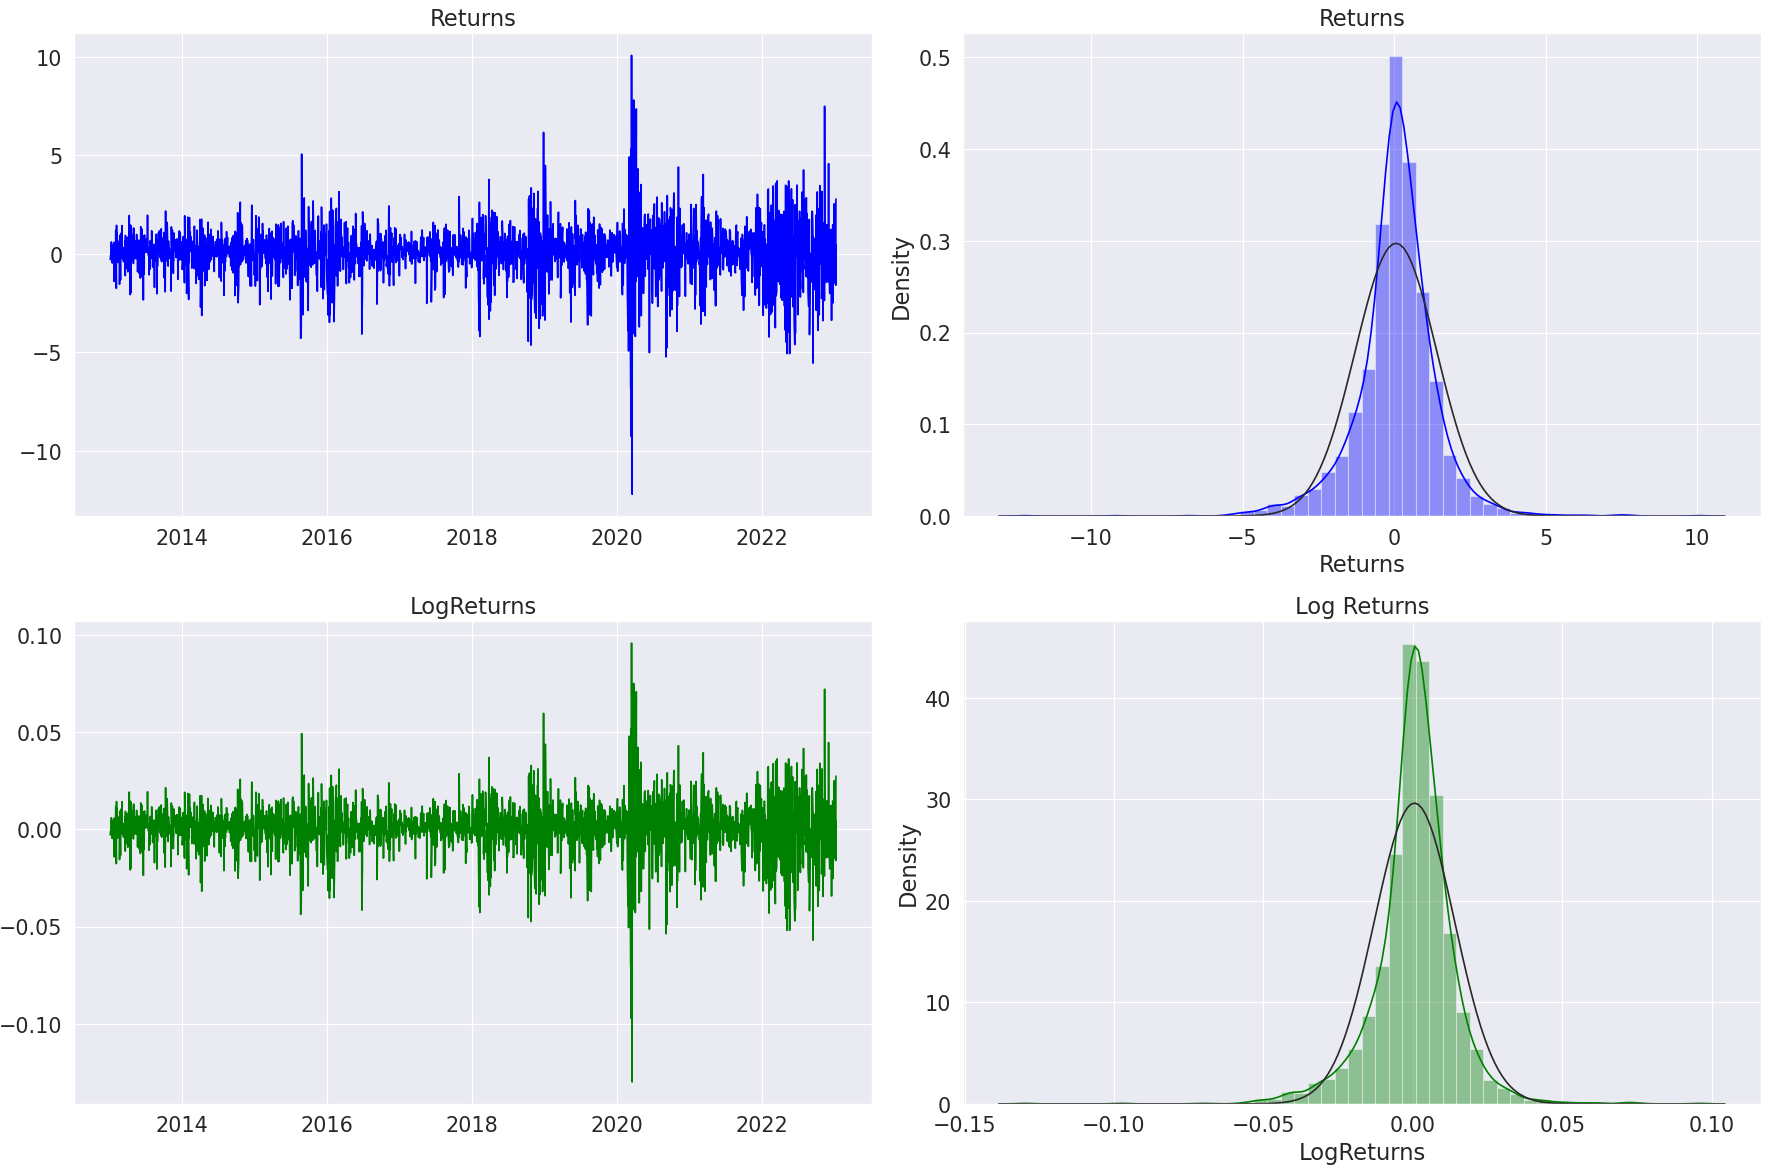

In [316]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(price.Returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(price.Returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(price.LogReturns, color='green')
    axes[1][0].set_title('LogReturns')

    sns.distplot(price.LogReturns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()

    fig.show()

usare r^2 come proxy della varianza. 

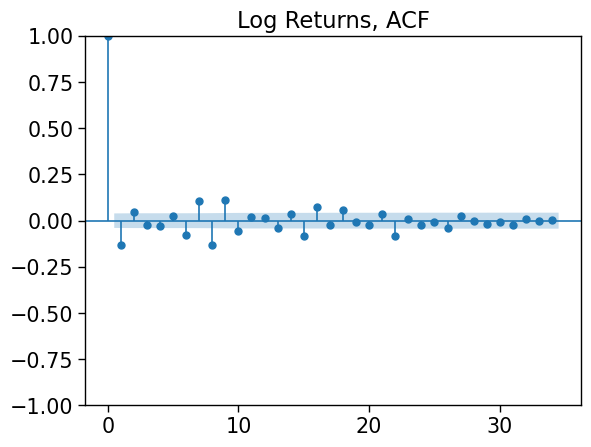

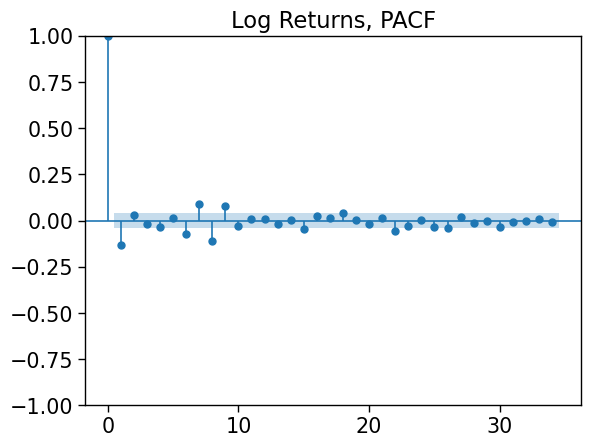

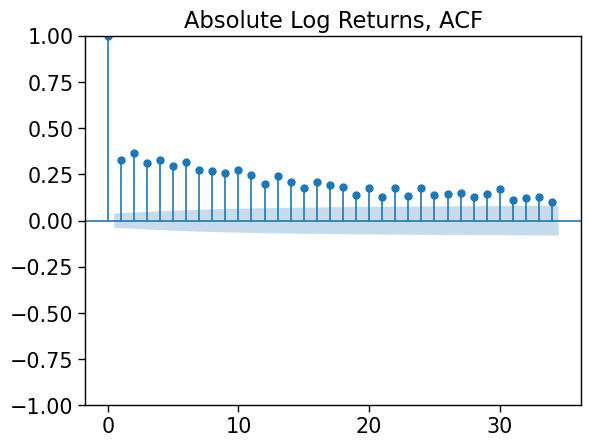

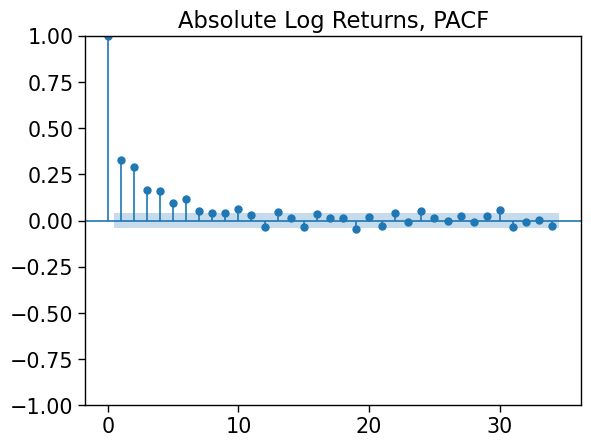

In [487]:
acf_lr = plot_acf(price.LogReturns, title= "Log Returns, ACF")
pacf_lr = plot_pacf(price.LogReturns, title= "Log Returns, PACF")
acf_abs_lr = plot_acf(abs(price.LogReturns), title= "Absolute Log Returns, ACF")
pacf_abs_lr = plot_pacf(abs(price.LogReturns), title= "Absolute Log Returns, PACF")

As can be noticed from the last plot, while it shows that for returns there is no time dependence, it easy to see that we observe time dependence in returns squared, which suggests us that the volatility of the process may be modeled through an ARCH-type model.

In [318]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

In [319]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show()

In [320]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show()

## Computing Realized Volatility

In [321]:
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [322]:
intervals = [7, 30, 180]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = price.LogReturns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=price.index)

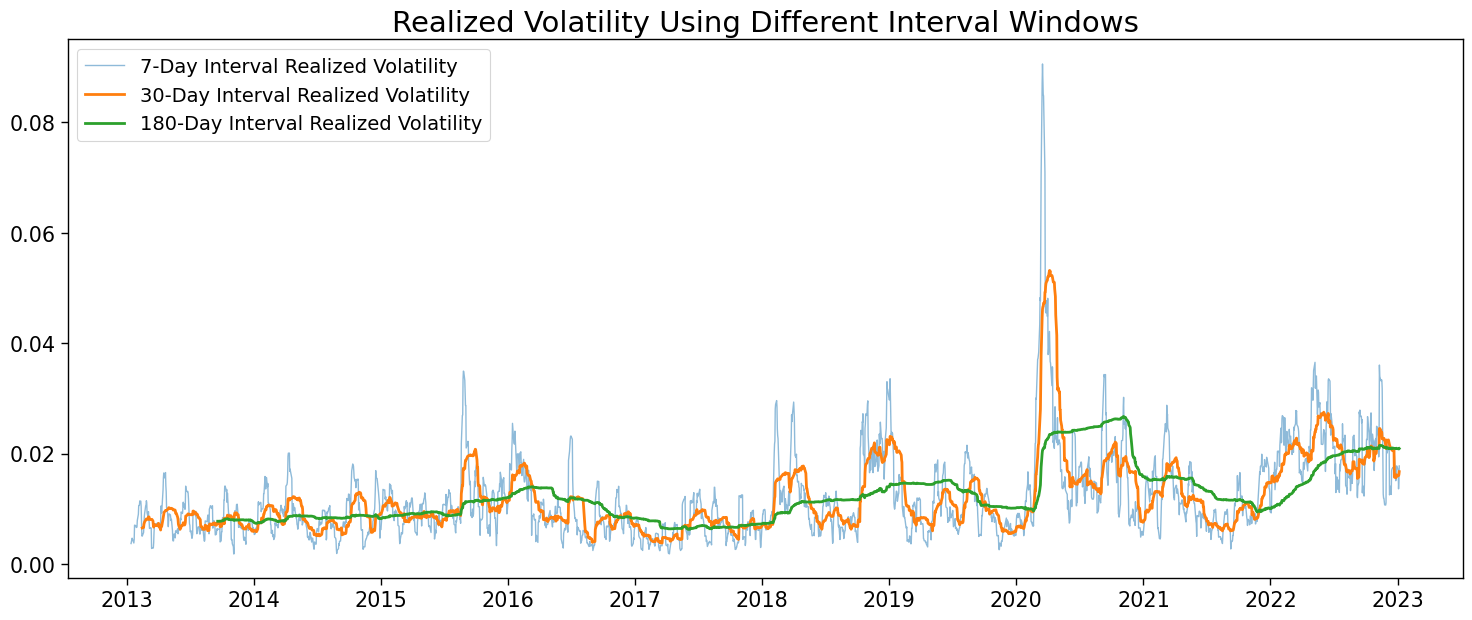

In [323]:
fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})
plt.show()

In [324]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
price['vol_current'] = price.LogReturns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
price['vol_future'] = price.LogReturns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [325]:
price.dropna(inplace=True)
price.describe()

Open          High           Low         Close        Volume  \
count   2484.000000   2484.000000   2484.000000   2484.000000  2.484000e+03   
mean    7433.623017   7486.811464   7375.229319   7434.531096  2.801358e+09   
std     3793.460776   3828.281931   3752.733805   3792.249393  1.446187e+09   
min     2708.800049   2718.060059   2689.830078   2700.969971  2.441200e+08   
25%     4372.134888   4395.072632   4349.562500   4375.877441  1.822082e+09   
50%     6478.675049   6531.729980   6415.364990   6469.329834  2.112400e+09   
75%    10554.990234  10672.022461  10500.474854  10602.672363  3.874335e+09   
max    16644.769531  16764.859375  16523.830078  16573.339844  1.162119e+10   

       Dividends  Stock Splits      Returns   LogReturns  vol_current  \
count     2484.0        2484.0  2484.000000  2484.000000  2484.000000   
mean         0.0           0.0     0.063968     0.000548     0.011937   
std          0.0           0.0     1.347629     0.013515     0.006744   
min          0.0           0.0   -12.193223    -0.130032     0.003804   
25%          0.0           0.0    -0.469556    -0.004707     0.007540   
50%          0.0           0.0     0.114918     0.001149     0.009641   
75%          0.0           0.0     0.723932     0.007213     0.015265   
max          0.0           0.0    10.072207     0.095966     0.053152   

        vol_future  
count  2484.000000  
mean      0.011961  
std       0.006743  
min       0.003804  
25%       0.007556  
50%       0.009658  
75%       0.015344  
max       0.053152

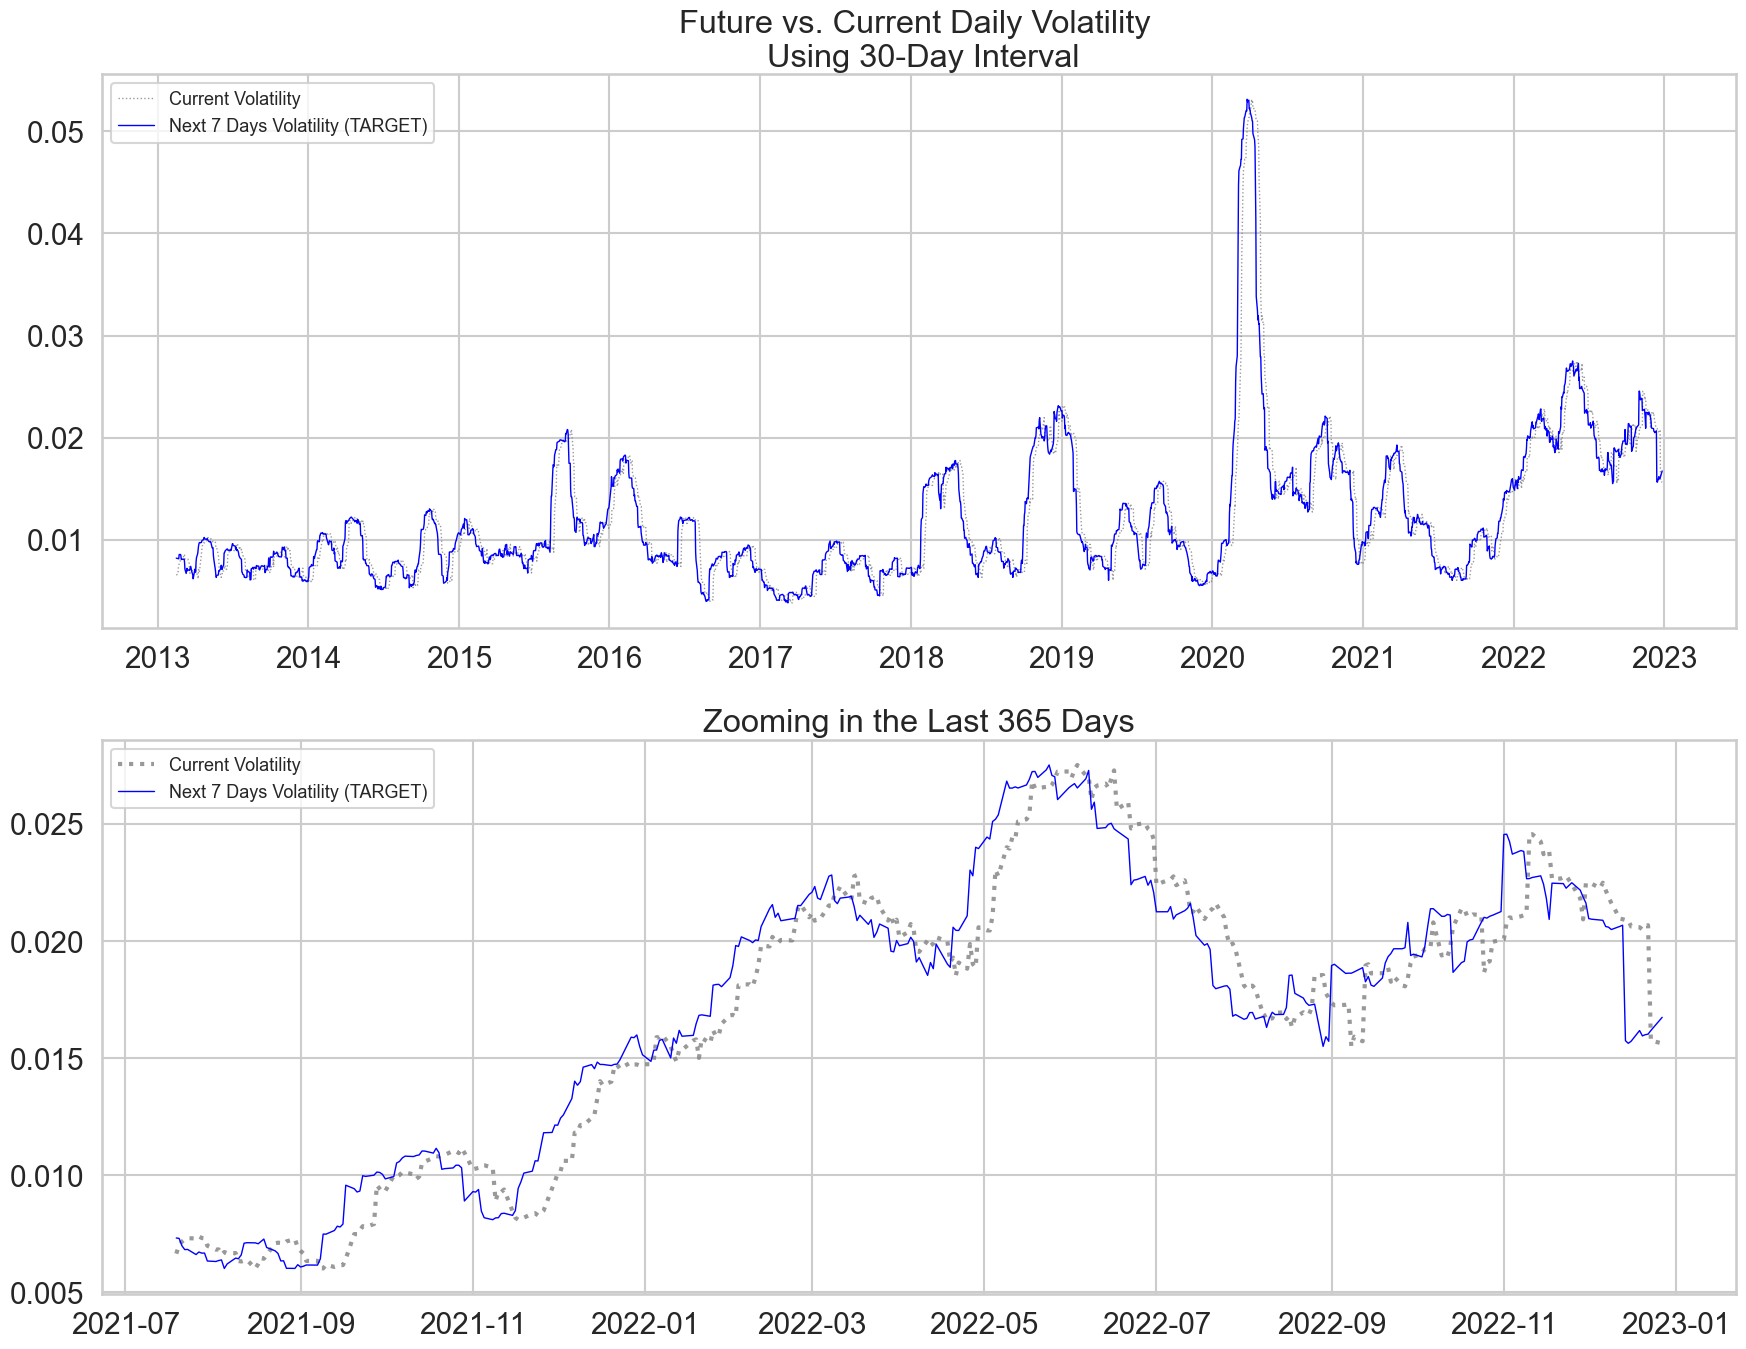

In [326]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)
# plt.style.use(['seaborn'])

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(price.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(price.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(price.vol_current[-n_zoom:], alpha=.8, lw=3, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(price.vol_future[-n_zoom:], lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    plt.show()

## Daily volatility grouped by month

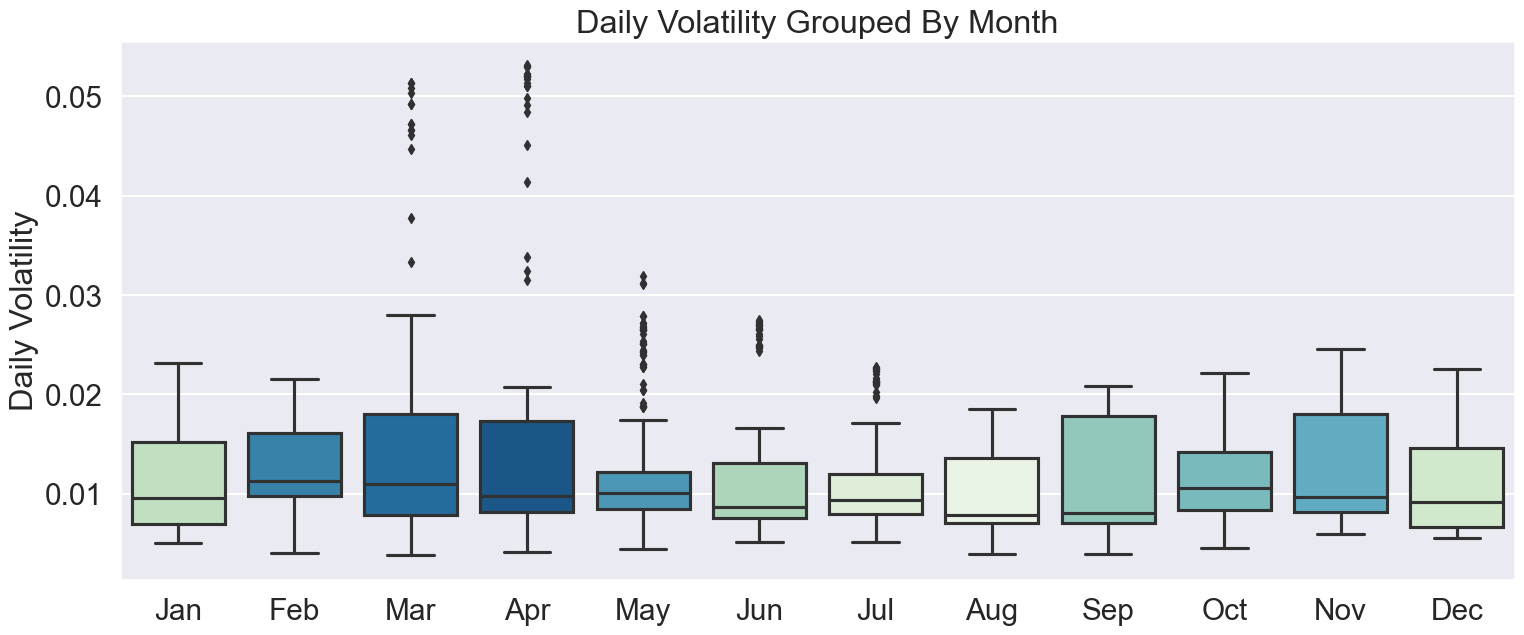

In [327]:
# PRESORT MONTHS IN CHRONOLOGICAL ORDER 
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 
                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
data = price.groupby(by=[price.index.month_name()]).vol_current.mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=[x[:3] for x in price.index.month_name()], 
                y=price.vol_current, 
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Month')
    plt.show()

## Volatility grouped by year

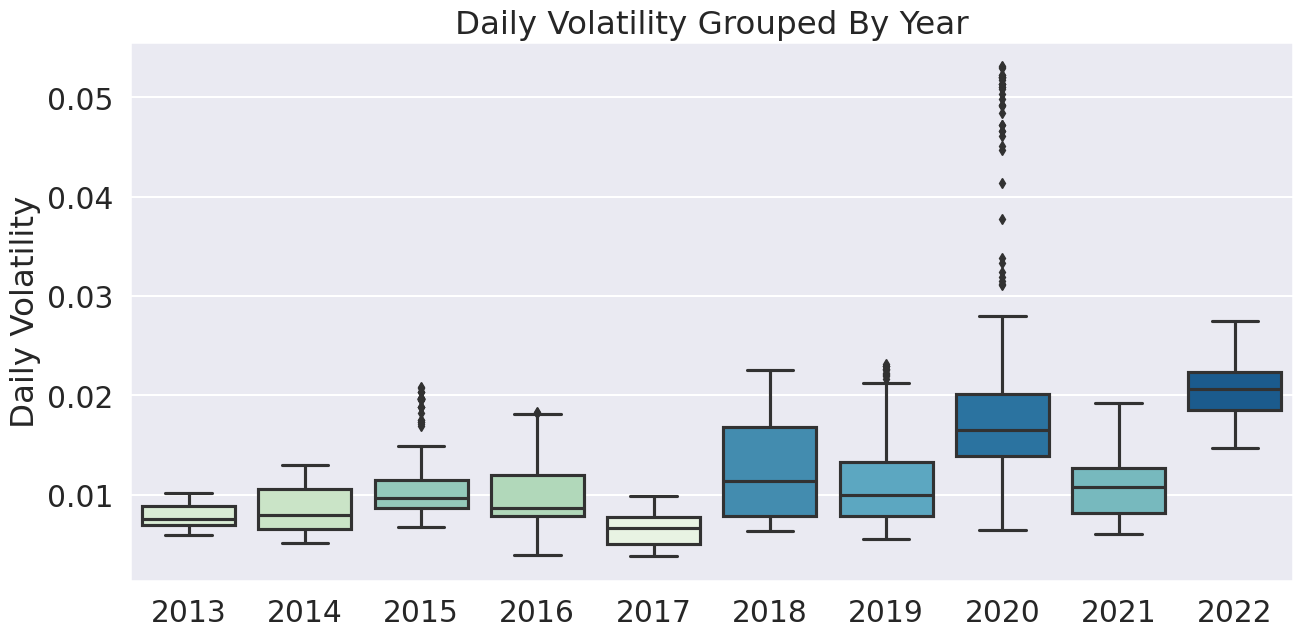

In [328]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = price.groupby(by=[price.index.year]).vol_current.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(15,7))
    
    sns.boxplot(x=price.index.year, 
                y=price.vol_current, 
                palette=np.array(pal)[rank])
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Year')

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


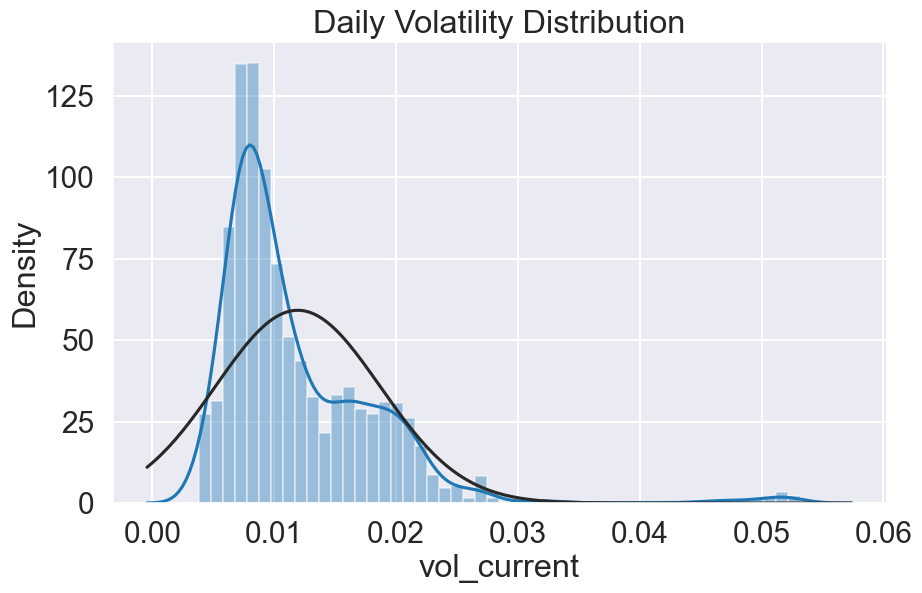

In [329]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(price.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.show()

### Train - Test - Validation Splitting

In [330]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 180
val_size = 360

# CONVERT TO INDICES
split_time_1 = len(price) - (val_size + test_size)
split_time_2 = len(price) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = price.index[:split_time_1]
val_idx = price.index[split_time_1:split_time_2]
test_idx = price.index[split_time_2:]

In [331]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2013-02-15 00:00:00-05:00 	to: 2020-11-03 00:00:00-05:00 	1944 days
VALIDATION 	From: 2020-11-04 00:00:00-05:00 	to: 2022-04-08 00:00:00-04:00 	360 days
TEST 		From: 2022-04-11 00:00:00-04:00 	to: 2022-12-27 00:00:00-05:00 	180 days


In [332]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = price.vol_future[train_idx]
y_val = price.vol_future[val_idx]
y_test = price.vol_future[test_idx]

In [333]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input NN models)
x_train = price.vol_current[train_idx]
x_val = price.vol_current[val_idx]
x_test = price.vol_current[test_idx]

In [334]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = price.Returns[train_idx]
r_val = price.Returns[val_idx]
r_test = price.Returns[test_idx]

In [335]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = price.LogReturns[train_idx]
lr_val = price.LogReturns[val_idx]
lr_test = price.LogReturns[test_idx]

In [336]:
y_train.describe()

count    1944.000000
mean        0.010934
std         0.006655
min         0.003804
25%         0.007283
50%         0.008879
75%         0.012175
max         0.053152
Name: vol_future, dtype: float64

In [337]:
x_train.describe()

count    1944.000000
mean        0.010892
std         0.006641
min         0.003804
25%         0.007270
50%         0.008860
75%         0.012153
max         0.053152
Name: vol_current, dtype: float64

### Data Normalization

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


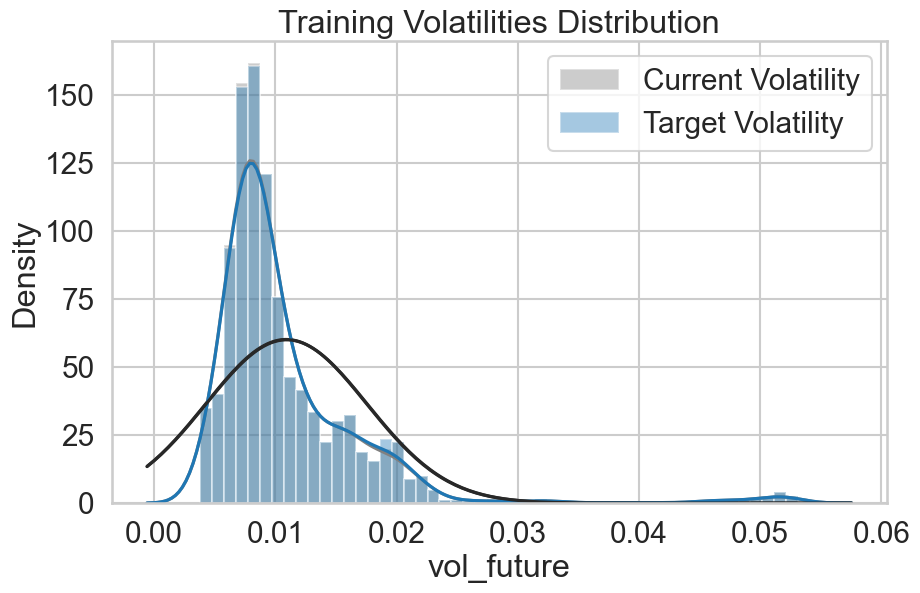

In [338]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    plt.show();

Here a function for scaling data is defined and implemented:

In [339]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [340]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [341]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


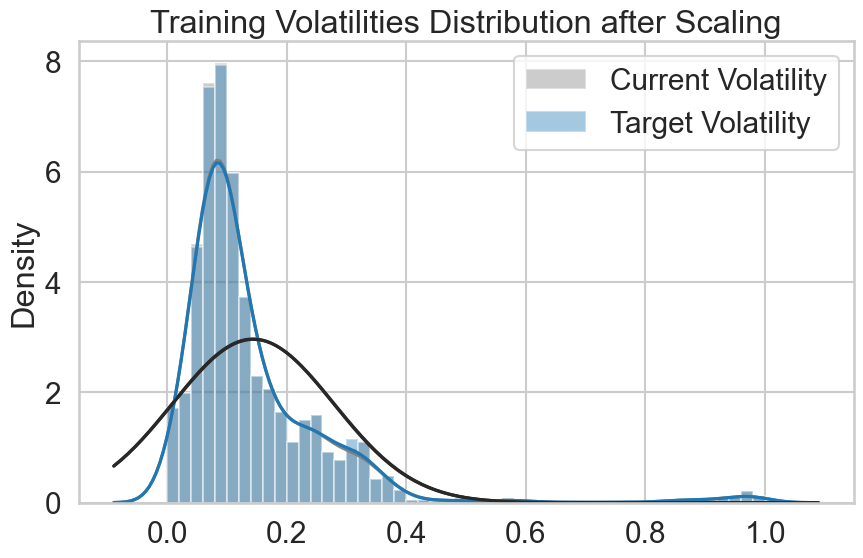

In [342]:
# PLOTTING VOLATILITIES AFTER SCALING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.show();

## Final Time Series Visualization:

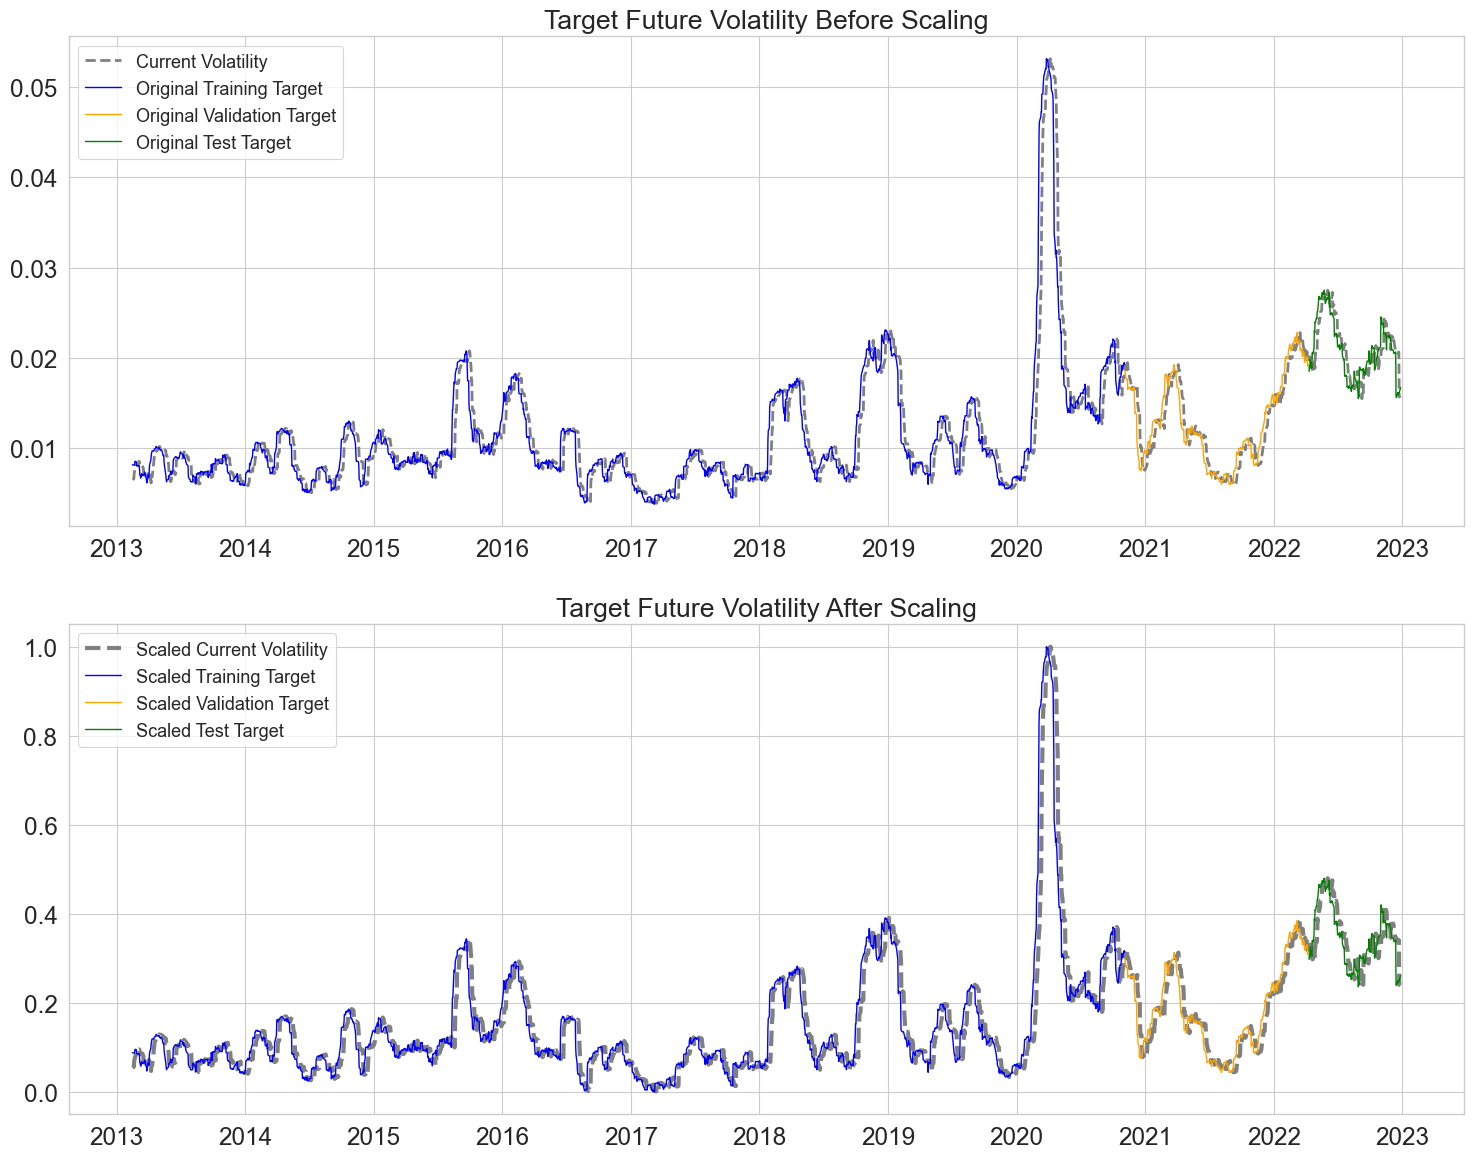

In [494]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(price.vol_current, lw=2, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=1)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=1)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=1)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, price.vol_current), 
                lw=3, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=1)
    ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=1)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=1)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)

    plt.show()

After scaling data falls in the range 0 1 and not in the original range.

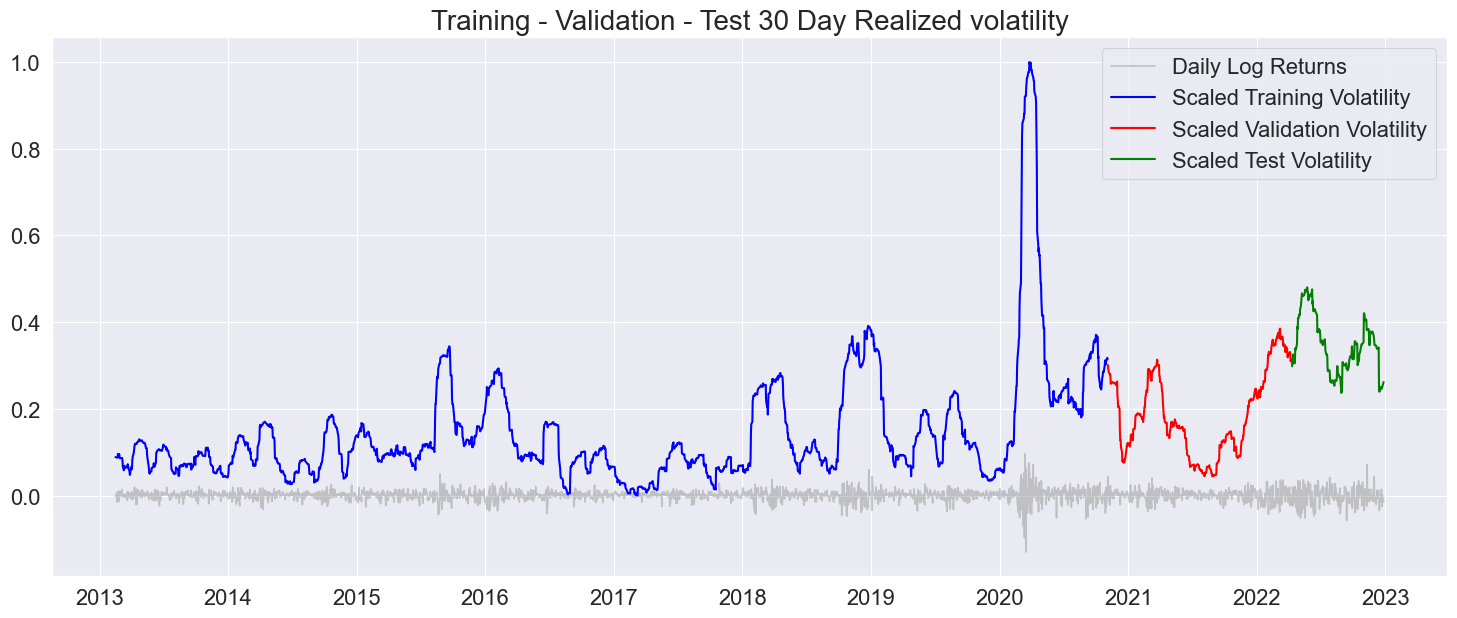

In [516]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(price.LogReturns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue', 
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red', 
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green', 
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training - Validation - Test 30 Day Realized volatility', fontsize=20)
    plt.legend(frameon=True)
    
    plt.show()

## Evaluation metrics:

In [345]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [346]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [347]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [348]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

# Modeling

## ARCH - Type Models:

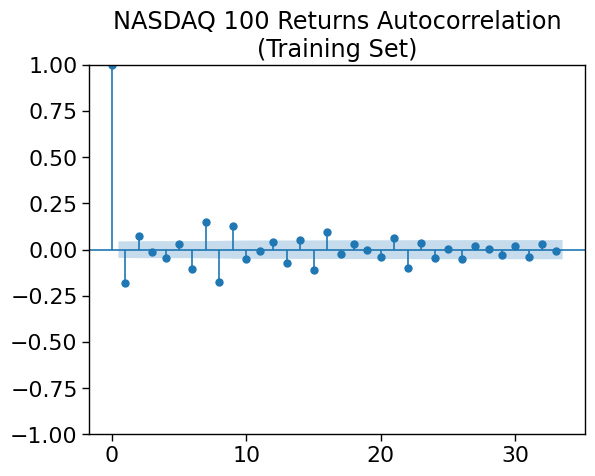

In [349]:
plot_acf(r_train,
          title='NASDAQ 100 Returns Autocorrelation\n(Training Set)')
plt.show()

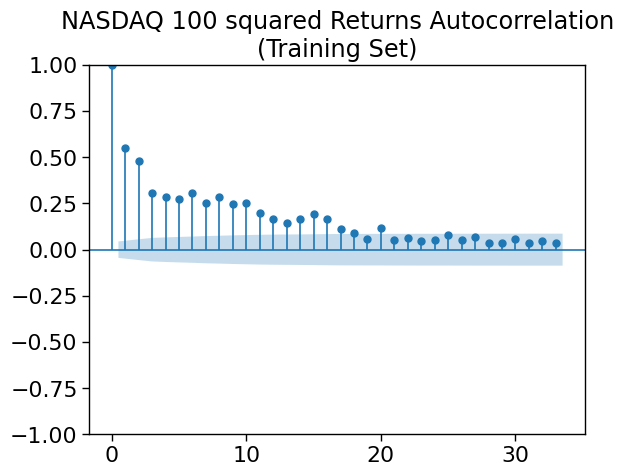

In [350]:
plot_acf(r_train**2,
          title='NASDAQ 100 squared Returns Autocorrelation\n(Training Set)')
plt.show()

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


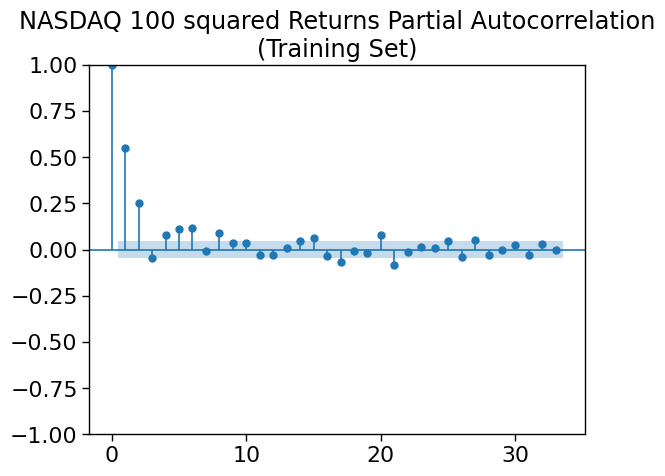

In [351]:
plot_pacf(r_train**2,
          title='NASDAQ 100 squared Returns Partial Autocorrelation\n(Training Set)')
plt.show()

### ARCH Test

In [352]:
print(diagnostic.het_arch(price.LogReturns))

(741.1281703782385, 9.247093039374166e-153, 105.33950938772176, 2.9071883200538293e-182)


The second value displayed above is the p-value for the ARCH Test, in which H0 is taht the process is homoskedasticity. Given that p-value is zero, we reject the null and figure out a statistically significant persistency in the series of squared returns.

## GARCH Model

In [353]:
garch_11 = arch_model(r_train, vol='GARCH', p=1, q=1)
garch_11_fit = garch_11.fit(disp='off')
print()
print(garch_11_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2756.38
Distribution:                  Normal   AIC:                           5520.75
Method:            Maximum Likelihood   BIC:                           5543.04
                                        No. Observations:                 1944
Date:                Sat, Jan 14 2023   Df Residuals:                     1943
Time:                        18:05:20   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1051  2.123e-02      4.950  7.411e-07 [6.347e-

In [354]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [355]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol_garch = scale_tf_cond_vol(garch_11_fit)

# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=1,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=1,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show()

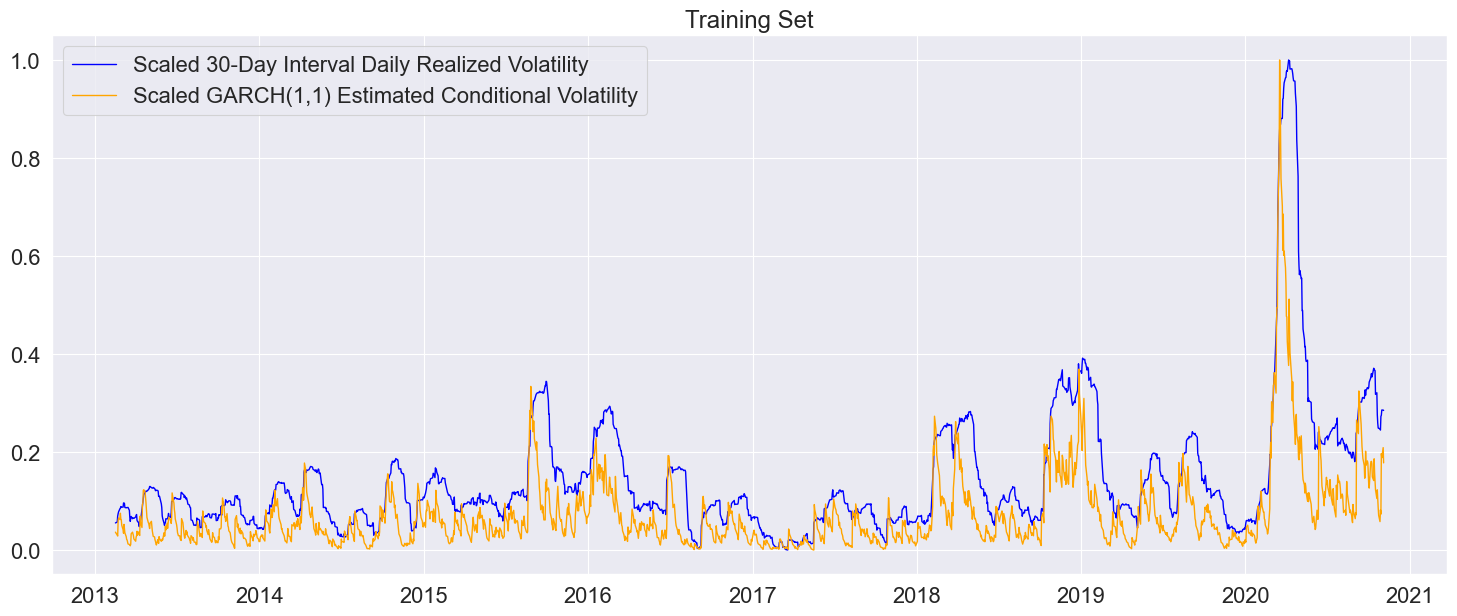

In [356]:
viz_cond_vol(scaled_cond_vol_garch, 'GARCH(1,1)')

In [357]:
train = price.Returns[:val_idx[0]]
garch = arch_model(train, vol = "GARCH", p=1, q=1, dist = "normal")
garch_fit = garch.fit()

pred = garch_fit.forecast(horizon=n_future).variance.values
pred

Iteration:      1,   Func. Count:      6,   Neg. LLF: 110257813406.66437
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1662998001.4252505
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3699.1992269309817
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3403.099581007834
Iteration:      5,   Func. Count:     35,   Neg. LLF: 4996.276728985727
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2761.028504702077
Iteration:      7,   Func. Count:     46,   Neg. LLF: 2760.844831204664
Iteration:      8,   Func. Count:     51,   Neg. LLF: 2760.823344952257
Iteration:      9,   Func. Count:     56,   Neg. LLF: 2760.8222338259347
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2760.8222263159073
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2760.822226315089
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2760.8222263159073
            Iterations: 11
            Function evaluations: 65
            Gradient evaluatio

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [5.72849046, 5.5359593 , 5.35206793, ..., 5.0086711 , 4.84844163,
        4.69540242]])

In [358]:
rolling_predictions_garch = []
idx = price.index

for i in range(len(val_idx)):
    idx = val_idx[i]
    train = price.Returns[:idx].dropna()
    garch = arch_model(train, vol = "GARCH", p=1, q=1, dist = "normal")
    garch_fit = garch.fit()
    pred = garch_fit.forecast(horizon=n_future).variance.values
    rolling_predictions_garch.append(np.sqrt(np.mean(pred[-1])))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 110257813406.66437
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1662998001.4252505
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3699.1992269309817
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3403.099581007834
Iteration:      5,   Func. Count:     35,   Neg. LLF: 4996.276728985727
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2761.028504702077
Iteration:      7,   Func. Count:     46,   Neg. LLF: 2760.844831204664
Iteration:      8,   Func. Count:     51,   Neg. LLF: 2760.823344952257
Iteration:      9,   Func. Count:     56,   Neg. LLF: 2760.8222338259347
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2760.8222263159073
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2760.822226315089
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2760.8222263159073
            Iterations: 11
            Function evaluations: 65
            Gradient evaluatio

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2478185966546.209
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1745751675.1763568
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3699.204259285844
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3353.305927345679
Iteration:      5,   Func. Count:     35,   Neg. LLF: 4994.553750887019
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2763.3704011227373
Iteration:      7,   Func. Count:     46,   Neg. LLF: 2763.163104980631
Iteration:      8,   Func. Count:     51,   Neg. LLF: 2763.1396470815343
Iteration:      9,   Func. Count:     56,   Neg. LLF: 2763.1379025764936
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2763.137882079701
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2763.1378820787154
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2763.137882079701
            Iterations: 11
            Function evaluations: 65
            Gradient evaluation

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      7,   Func. Count:     46,   Neg. LLF: 2769.2298677466997
Iteration:      8,   Func. Count:     51,   Neg. LLF: 2769.2079806701186
Iteration:      9,   Func. Count:     56,   Neg. LLF: 2769.206188418675
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2769.2061817776994
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2769.2061817766717
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2769.2061817776994
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      6,   Neg. LLF: 47582172444.0382
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1686226864.9288874
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3716.4061325393395
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3331.8393421168657
Iteration:      5,   Func. Count:     35,   Neg. LLF: 4976.236311462199
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2771.66550

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2810489675843.201
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1666737988.1279016
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3718.0851271831316
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3391.912293855762
Iteration:      5,   Func. Count:     35,   Neg. LLF: 4966.041220372205
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2773.31753364784
Iteration:      7,   Func. Count:     46,   Neg. LLF: 2773.1240316448675
Iteration:      8,   Func. Count:     51,   Neg. LLF: 2773.103836327535
Iteration:      9,   Func. Count:     56,   Neg. LLF: 2773.102244680268
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2773.1022399994627
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2773.102239998516
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2773.1022399994627
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2717733064881.8066
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1689233372.2526307
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3439.9478119374726
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3459.141596333067
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2793.660178820921
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2781.8535692302776
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2780.305082244765
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2780.2883917420104
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2780.2822645494343
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2780.282071287191
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2780.2820655562737
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2780.2820655561427
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2780.2820655562737
            Iterati

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2554886744903.8223
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1723126363.0621324
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3448.388353089242
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3476.9123282762944
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2804.9489112324654
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2792.9667459652783
Iteration:      7,   Func. Count:     47,   Neg. LLF: 2791.7260533574454
Iteration:      8,   Func. Count:     52,   Neg. LLF: 2791.5603908868316
Iteration:      9,   Func. Count:     57,   Neg. LLF: 2791.536576957421
Iteration:     10,   Func. Count:     62,   Neg. LLF: 2791.533847981893
Iteration:     11,   Func. Count:     67,   Neg. LLF: 2791.532964569884
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2791.532962648309
Iteration:     13,   Func. Count:     76,   Neg. LLF: 2791.5329626476428
Optimization terminated successfully    (Exit mode 0)
  

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 95819315593.51495
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1786604630.019866
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3454.197457379596
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3487.499636525986
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2814.2631512408425
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2803.5160254827547
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2800.235279387017
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2800.208623755614
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2800.199975393256
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2800.199295342605
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2800.1992790177082
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2800.199279016455
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2800.1992790177082
            Iterations: 

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 60511653716.70025
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1797262538.9697354
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3458.4623754333597
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3497.317335898665
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2819.709939479441
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2809.057048188469
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2805.752871959278
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2805.7251836188316
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2805.7170619422286
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2805.7162049122176
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2805.716187212154
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2805.7161872108272
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2805.716187212154
            Iterations

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30771519589.354343
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1781647304.2077708
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3461.4989925177088
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3509.25571632451
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2823.3047932951904
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2812.365820310264
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2809.8542017600994
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2809.8326364829177
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2809.8257560701795
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2809.825365134971
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2809.825355254387
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2809.8253552537317
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2809.825355254387
            Iteration

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 392160553542.1555
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1828868362.8769083
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3469.8991677555623
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3508.4588627946937
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2830.707815015492
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2821.038040728139
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2816.5008229542336
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2816.460098183875
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2816.4516743096947
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2816.449664017697
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2816.4496459288125
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2816.44964592787
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2816.4496459288125
            Iterations

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      3,   Func. Count:     22,   Neg. LLF: 3484.0188400072525
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3514.157864584384
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2841.565127252393
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2835.7866148422786
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2827.016759025449
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2826.9465920771227
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2826.934520980655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2826.930199484199
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2826.930168507906
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2826.930168507445
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2826.930168507906
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2483407935354.

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     10,   Func. Count:     63,   Neg. LLF: 2833.8231066278636
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2833.823079174799
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2833.8230791743913
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2833.823079174799
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2324837058437.415
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1863465215.8844209
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3493.957240938914
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3523.458814899136
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2851.633614722886
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2847.9505905770643
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2836.8676212938317
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2836.7762521

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     10,   Func. Count:     63,   Neg. LLF: 2841.6561807194307
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2841.656151192281
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2841.656151191866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2841.656151192281
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2322849156798.671
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1892217085.7253993
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3503.1846613053003
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3547.567946236244
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2861.895341814662
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2867.006714772103
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2846.8602080863743
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2846.70820031

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      3,   Func. Count:     22,   Neg. LLF: 3512.722210277494
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3558.598750267857
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2869.9020167417966
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2878.673309533754
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2855.1598909916816
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2854.9894150736427
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2854.9669927320406
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2854.9582131739135
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2854.9578781040113
Iteration:     12,   Func. Count:     73,   Neg. LLF: 2854.9578666523203
Iteration:     13,   Func. Count:     77,   Neg. LLF: 2854.9578666530797
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2854.9578666523203
            Iterations: 13
            Function evaluations: 77
            Gradient evalua

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     11,   Func. Count:     68,   Neg. LLF: 2860.5484959036685
Iteration:     12,   Func. Count:     73,   Neg. LLF: 2860.5484909135903
Iteration:     13,   Func. Count:     77,   Neg. LLF: 2860.5484909140423
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2860.5484909135903
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 37879344311.96626
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2004689772.803416
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3518.5766823009526
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3559.8755672518364
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2877.249518417859
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2878.105971110708
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2861.8025736665454
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2861.67168

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     12,   Func. Count:     72,   Neg. LLF: 2865.5524332471127
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2865.552433247493
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 759019236561.6294
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1978752841.1701314
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3523.524608798856
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3560.4839480240435
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2882.246032466932
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2875.730459457001
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2866.6782919066386
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2866.605720273843
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2866.5930228252023
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2866.5884304

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 35029020922.84098
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1985129374.7636507
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3532.644114282045
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3570.959506781722
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2894.4178036709473
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2906.2274032395117
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2877.9368124079365
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2877.702047088314
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2877.671758767103
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2877.660765300369
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2877.6597811899687
Iteration:     12,   Func. Count:     73,   Neg. LLF: 2877.6597213018254
Iteration:     13,   Func. Count:     77,   Neg. LLF: 2877.6597213034006
Optimization terminated successfully    (Exit mode 0)
   

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      7,   Func. Count:     48,   Neg. LLF: 2890.4033880411016
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2890.192495513525
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2890.1618199913273
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2890.148948907629
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2890.1480725039573
Iteration:     12,   Func. Count:     73,   Neg. LLF: 2890.1480265092787
Iteration:     13,   Func. Count:     77,   Neg. LLF: 2890.148026510948
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2890.1480265092787
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2818842576936.7896
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1789345716.6339583
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3552.81543340165
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3594.701747

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2806206021774.025
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1792895503.8786488
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3885.1461548190696
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3322.415255243357
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3848.559381029442
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2903.606256037902
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2903.1648826747514
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2903.1538657498063
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2903.1537585569486
Iteration:     10,   Func. Count:     62,   Neg. LLF: 2903.153758557334
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2903.1537585569486
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 28582237278

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      5,   Func. Count:     36,   Neg. LLF: 2927.0487637073793
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2931.789128516037
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2912.4905462915767
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2912.363911100203
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2912.3434413029645
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2912.3337809057
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2912.3336661293456
Iteration:     12,   Func. Count:     73,   Neg. LLF: 2912.3336652966445
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2912.3336652966445
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2476247481423.3945
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1884842202.9955666
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3577.733104

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2638009757686.1807
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1846474966.74225
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3585.9658908130946
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3638.0474594542507
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2937.1440881675444
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2941.0297095723286
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2922.587070625491
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2922.468075659262
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2922.4485350568048
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2922.440158767622
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2922.4400674679086
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2922.440067465849
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2922.4400674679086
            Iteration

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2329846837393.92
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1943891553.057705
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3598.8520084444735
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3656.3220981906275
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2952.5189268876884
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2953.011919498933
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2937.749947140971
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2937.644018069181
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2937.6258074046
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2937.6184340000436
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2937.618356635014
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2937.618356633826
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2937.618356635014
            Iterations: 12


c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2284164177043.2075
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1957277151.0847373
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3602.5100937398197
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3660.929286678637
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2957.447259737831
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2955.5445631856755
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2942.5025133290537
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2942.4041848516317
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2942.3873484533187
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2942.380741947557
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2942.3806771759196
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2942.3806771750087
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2942.3806771759196
            Iterat

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     11,   Func. Count:     68,   Neg. LLF: 2948.847896218622
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2948.8478962171566
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2948.847896218622
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2276210830575.326
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1975684419.6333556
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3608.9106957075433
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3672.264205837131
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2965.41603937608
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2964.87831722381
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2950.461820976737
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2950.352979271148
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2950.33527555241

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 38701956409.60957
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1988744112.3960743
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3614.9990394366223
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3680.6057680257595
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2972.5854975315597
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2972.610505463227
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2957.5562769050284
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2957.439507669892
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2957.421520904001
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2957.4140841649432
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2957.4140057938894
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2957.414005792026
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2957.4140057938894
            Iteratio

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2353642422861.0264
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1973235304.8550324
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3619.334181470159
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3689.1001872150027
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2977.8946004116224
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2975.9849966323195
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2962.9356454743047
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2962.827043165178
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2962.8105530061566
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2962.803899541743
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2962.8038358330077
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2962.8038358315916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2962.8038358330077
            Iterat

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     11,   Func. Count:     68,   Neg. LLF: 2969.5943868303743
Iteration:     12,   Func. Count:     73,   Neg. LLF: 2969.594382281196
Iteration:     13,   Func. Count:     77,   Neg. LLF: 2969.5943822816575
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2969.594382281196
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 91108989617.00853
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1948149770.7412686
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3632.1467589227177
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3694.78142438972
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2990.245456843474
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3006.1223010467143
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2974.6668926576376
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2974.4668360

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 250404356280.04047
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1935022655.253504
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3641.8413825025336
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3714.3793452589807
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2998.5585996017626
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3016.2804295138394
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2983.0824281784644
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2982.8977528984797
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2982.8698940261065
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2982.858014691273
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2982.8576187032295
Iteration:     12,   Func. Count:     73,   Neg. LLF: 2982.8576058232557
Iteration:     13,   Func. Count:     77,   Neg. LLF: 2982.857605824309
Optimization terminated successfully    (Exit mode 0)


c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      2,   Func. Count:     15,   Neg. LLF: 1941379647.116029
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3647.6159687971904
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3724.0343819461405
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3005.316587178024
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3020.0605062020904
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2989.4722772620635
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2989.295762545887
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2989.2691929596795
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2989.257884502082
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2989.2575635698095
Iteration:     12,   Func. Count:     73,   Neg. LLF: 2989.25755444137
Iteration:     13,   Func. Count:     77,   Neg. LLF: 2989.2575544422307
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2989.25755444137
            Iterations:

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1555101522166.445
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1953014234.8312097
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3653.7674705349477
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3728.3955600312675
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3012.4272168475154
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3020.1569639184995
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2996.1771470966632
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2996.026404717583
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2996.0034604651655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2995.993559971615
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2995.9933866688034
Iteration:     12,   Func. Count:     73,   Neg. LLF: 2995.993383788004
Iteration:     13,   Func. Count:     77,   Neg. LLF: 2995.993383788369
Optimization terminated successfully    (Exit mode 0)
  

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      4,   Func. Count:     30,   Neg. LLF: 3734.073378539121
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3019.5060547269877
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3026.9376440771207
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3003.0953191332355
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3002.9471733797373
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3002.9240325765095
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3002.913809300077
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3002.9136440641414
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3002.913641652915
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3002.913641653236
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3002.913641652915
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 18120869429

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      9,   Func. Count:     58,   Neg. LLF: 3007.079394789268
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3007.069813821672
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3007.069652089991
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3007.069649599024
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3007.0696495993393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3007.069649599024
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 32371046624.631268
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1937220171.2188115
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3664.848118373482
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3741.419323548028
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3024.505023910116
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3028.509543407

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      3,   Func. Count:     22,   Neg. LLF: 3670.197768694377
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3747.2328283102734
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3029.6888541987037
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3035.7478075712206
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3013.1609902858017
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3013.007829716829
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3012.985205651231
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3012.9755151676313
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3012.975325386168
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3012.975321775837
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3012.9753217762595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3012.975321775837
            Iterations: 13
            Function evaluations: 77
            Gradient evaluatio

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      2,   Func. Count:     15,   Neg. LLF: 1930048433.2009754
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3673.928854751899
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3751.822234155122
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3033.3048848735625
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3039.926145189841
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3016.7396500526784
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3016.5806616642876
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3016.5576595931047
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3016.5479107584374
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3016.547688059628
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3016.5476830207554
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3016.547683021291
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3016.5476830207554
            Iteratio

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 60862940478.20989
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1902751712.624519
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3678.7048130694957
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3757.850707727332
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3037.6038981529314
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3044.037927938094
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3021.0226822376053
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3020.8612279996555
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3020.8382837411664
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3020.828651537244
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3020.8284113982672
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3020.8284054585442
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3020.8284054591395
Optimization terminated successfully    (Exit mode 0)
  

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      9,   Func. Count:     58,   Neg. LLF: 3024.6920554299986
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3024.682945601507
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3024.682735219113
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3024.6827303742575
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3024.6827303747705
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3024.6827303742575
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 42622669563.23243
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1848526385.709678
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3683.9769891540946
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3766.8391686802497
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3042.0541602648605
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3045.78829

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 65499711420.20511
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1862045271.2952404
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3693.146126689463
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3778.2133528242675
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3048.8108846108207
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3049.936936754158
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3032.7738544182266
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3032.6423432780734
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3032.6236695052235
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3032.6160104769133
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3032.6159014498135
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3032.615900152544
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3032.6159001527176
Optimization terminated successfully    (Exit mode 0)
 

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     11,   Func. Count:     68,   Neg. LLF: 3037.849458256808
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3037.849449976923
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3037.8494499776352
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3037.849449976923
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 123422545017.07571
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1838941452.8196096
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3702.133432567502
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3784.5163460807225
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3056.0447195707698
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3064.944933942119
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3039.5629673799367
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3039.381367

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     10,   Func. Count:     63,   Neg. LLF: 3043.6773556307626
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3043.677000338638
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3043.6769878064715
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3043.6769878073555
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3043.6769878064715
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 45169097428.04994
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1858177682.1271334
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3708.5603653033877
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3792.430958919541
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3061.6327779275616
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3068.7256166266616
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3044.9640

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 193740938595.4792
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1834501513.579506
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3712.7068348978946
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3796.9984195873753
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3064.476736804955
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3064.7849682874125
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3048.073813121187
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3047.9481314638415
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3047.9302382079395
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3047.922914975355
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3047.922819399029
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3047.9228184004955
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3047.9228184004955
            Iteration

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 189225783821.77664
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1863319184.3022895
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3717.889145443219
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3804.2838180130866
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3067.75844404273
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3064.086136201898
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3051.845889826794
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3051.7528779207114
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3051.7379629534353
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3051.7323685589326
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3051.732315897159
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3051.7323158962427
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3051.732315897159
            Iterations

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 14709418551.65659
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1930271748.5829115
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3726.1451639414536
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3807.2628280460876
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3073.537490843043
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3073.599211141622
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3057.2271557645845
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3057.1021171340485
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3057.084584116827
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3057.0774926341137
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3057.077398852834
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3057.0773978714437
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3057.0773978714437
            Iteratio

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31729874258.99259
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1870752043.6710753
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3732.9348583908663
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3812.8935062076157
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3079.0751001937574
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3083.592212102034
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3062.4119324403705
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3062.2558970757254
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3062.235320385011
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3062.227079885047
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3062.2268491193604
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3062.226842810236
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3062.2268428108273
Optimization terminated successfully    (Exit mode 0)
  

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     12,   Func. Count:     73,   Neg. LLF: 3066.947975671493
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3066.947975672275
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3066.947975671493
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3016873866826.3716
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1849799799.6629534
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3739.847361534232
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3819.545526929306
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3084.6755386978134
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3088.5913722033906
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3067.8880632567966
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3067.7354338470413
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3067.715306

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3105313309954.749
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1833259326.8413265
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3743.680532442176
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3823.2066338236536
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3086.891586930683
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3082.8322410736628
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3070.5473301379034
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3070.4558101919647
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3070.4411854878554
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3070.435638177963
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3070.4355878329134
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3070.4355878320057
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3070.4355878329134
            Iterati

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2988973136290.523
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1876237327.877263
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3750.3273955232044
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3828.442846412296
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3091.4577100987544
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3087.499337422617
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3075.1694364475125
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3075.076781150876
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3075.062189726906
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3075.056661957444
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3075.0566122777036
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3075.056612276781
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3075.0566122777036
            Iterations:

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3158417179256.81
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1868635654.90033
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3773.109784701953
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3852.289443137789
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3111.8271196902424
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3287.2095538953117
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3094.052591748803
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3093.7569279676454
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3093.713389191694
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3093.6977310188877
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3093.6961160492788
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3093.6959998060297
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3093.695999149988
Optimization terminated successfully    (Exit mode 0)
      

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3210569434670.464
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1860274684.888413
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3781.5950154656334
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3864.8758796996817
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3120.6610773045995
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3404.348253571693
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3102.602368988737
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3102.3088710335237
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3102.26533260577
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3102.249038631978
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3102.247620563581
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3102.247527530566
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3102.2475269359893
Optimization terminated successfully    (Exit mode 0)
      

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 63479329780.867935
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1872071476.6326447
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3787.6622718493763
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3866.931891520009
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3127.5290027311944
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3277.432258556295
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3108.90713727528
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3108.5906397189024
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3108.544595204175
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3108.52949175728
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3108.5276741256166
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3108.5275289362744
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3108.5275281545746
Optimization terminated successfully    (Exit mode 0)
    

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2945004790184.496
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1912818951.564601
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3794.9685185350027
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3875.157566563889
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3135.159080726842
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3355.368276869064
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3116.2730898313775
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3115.9559475753413
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3115.9094845662185
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3115.8935167136356
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3115.8918155368583
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3115.8916885404246
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3115.891687806129
Optimization terminated successfully    (Exit mode 0)
   

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      9,   Func. Count:     58,   Neg. LLF: 3120.625475023271
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3120.609890530368
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3120.6080675709795
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3120.607923130283
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3120.607922333333
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3120.607922333333
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 41918933242.15633
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1900298118.8998067
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3800.667331414027
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3880.787540665652
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3140.872930143432
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3294.9763881021

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 122804828685.40868
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1875304532.0104249
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3804.942885189299
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3886.9479427580177
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3144.7767785403134
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3263.3878173763123
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3125.8602267487577
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3125.515073778648
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3125.4651143030965
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3125.4505064600853
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3125.4484867942706
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3125.4483062674717
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3125.4483053174836
Optimization terminated successfully    (Exit mode 0)

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     13,   Func. Count:     78,   Neg. LLF: 3130.1712126275543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3130.1712126275543
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 261223005574.72565
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1844043826.2874668
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3811.1853097951803
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3893.8951146827353
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3150.315635224477
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3275.539834743783
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3131.3769038359014
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3131.0231281144816
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3130.9720598725416
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3130.957

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      6,   Func. Count:     42,   Neg. LLF: 3433.253212942178
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3137.3903299825006
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3137.0552616312375
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3137.0067390476797
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3136.9907348881106
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3136.988896453395
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3136.988750175631
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3136.988749365122
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3136.988749365122
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 111664205129.75677
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1892541868.8196578
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3819.060193

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      2,   Func. Count:     15,   Neg. LLF: 1869471107.3816786
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3823.833430081494
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3904.392406255508
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3161.903311747279
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3360.232482206864
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3142.413628122187
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3142.0593775661905
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3142.008546860903
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3141.9932392447577
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3141.991211201728
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3141.9910315231236
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3141.9910305617464
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3141.9910305617464
            Iterations

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      8,   Func. Count:     53,   Neg. LLF: 3150.059952648077
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3150.0111266949834
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3149.9918998407957
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3149.990409707908
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3149.990315195849
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3149.990314533716
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3149.990314533716
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3015247393264.92
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1938176445.1880994
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3837.4353617410375
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3916.0647763613406
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3173.36239945

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 295845389230.98474
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1851542928.629111
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3845.8733872773882
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3928.462757345996
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3180.6524580816376
Iteration:      6,   Func. Count:     42,   Neg. LLF: 4451.931223934182
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3160.742135061065
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3160.420552185286
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3160.370184679331
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3160.34881356187
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3160.3473642288554
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3160.3472782280114
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3160.347277564697
Optimization terminated successfully    (Exit mode 0)
      

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      8,   Func. Count:     53,   Neg. LLF: 3168.7672598544395
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3168.715611786648
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3168.6930818848386
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3168.691755851546
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3168.691683835483
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3168.691683206849
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3168.691683206849
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3161747113261.9546
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1908395267.8158383
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3856.366039611965
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3944.984668946377
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3190.43535091

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3563967901884.579
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1834251739.5734448
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3866.878946282807
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3957.4156521608693
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3198.491434602447
Iteration:      6,   Func. Count:     42,   Neg. LLF: 4466.144749517748
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3179.5807384797226
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3179.2730991838503
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3179.222383864254
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3179.199365281721
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3179.1982730265963
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3179.1982220440054
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3179.1982215379085
Optimization terminated successfully    (Exit mode 0)
   

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      8,   Func. Count:     53,   Neg. LLF: 3192.330017650514
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3192.280121780016
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3192.258716056256
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3192.257421673957
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3192.25735108541
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3192.2573504936818
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3192.2573504936818
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 27436091016.22677
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1893911739.5157318
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3880.1298961966368
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3965.874513922626
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3213.637334874

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 187551636979.51422
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1830514675.833672
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3888.9825082004363
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3978.6516975740997
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3222.5708534063915
Iteration:      6,   Func. Count:     42,   Neg. LLF: 4471.690341675387
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3203.45440980489
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3203.175054184792
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3203.1263592698483
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3203.102898153028
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3203.1021092521214
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3203.102082106297
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3203.102082108267
Optimization terminated successfully    (Exit mode 0)
     

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:     10,   Func. Count:     63,   Neg. LLF: 3207.4953326842196
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3207.4943275024098
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3207.494284144294
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3207.4942841467596
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3207.494284144294
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3634634691803.29
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1840976163.6888194
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3894.0059018401435
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3987.629495414189
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3229.2567481223105
Iteration:      6,   Func. Count:     42,   Neg. LLF: 4481.791109214197
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3209.5914170

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 307378206972.3173
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1770579511.3572931
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3903.6383744306595
Iteration:      4,   Func. Count:     30,   Neg. LLF: 4012.963234642075
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3238.065517638367
Iteration:      6,   Func. Count:     42,   Neg. LLF: 4479.83951650428
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3218.8311011338556
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3218.582671047785
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3218.5368838092577
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3218.514970125807
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3218.51452169291
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3218.514513588848
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3218.5145135897783
Optimization terminated successfully    (Exit mode 0)
       

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      8,   Func. Count:     53,   Neg. LLF: 3226.6524057831866
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3226.607701548408
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3226.5864974730143
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3226.5860935447467
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3226.586087121665
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3226.586087122455
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3226.586087121665
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 221768322455.78326
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1647592135.4973283
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3916.015623116775
Iteration:      4,   Func. Count:     30,   Neg. LLF: 4033.828235060145
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3248.2723375

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 251779782945.55566
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1705072354.1020393
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3928.518803536621
Iteration:      4,   Func. Count:     30,   Neg. LLF: 4043.7516385420304
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3256.906405865787
Iteration:      6,   Func. Count:     42,   Neg. LLF: 4497.515789801804
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3239.0476941342285
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3238.8433711369753
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3238.8019220170677
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3238.7827165206827
Iteration:     11,   Func. Count:     68,   Neg. LLF: 3238.7824194055574
Iteration:     12,   Func. Count:     73,   Neg. LLF: 3238.7824175318783
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3238.782417532253
Optimization terminated successfully    (Exit mode 0)
 

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 57888111689.89273
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1645446745.0548077
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4435.554714258107
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3637.8406792389032
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3487.258200823979
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3261.0558368799434
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3259.5750361470764
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3259.5518361088707
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3259.5505384017224
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3259.550535778372
Iteration:     11,   Func. Count:     67,   Neg. LLF: 3259.550535778319
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3259.550535778372
            Iterations: 11
            Function evaluations: 67
            Gradient evaluatio

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5872165469992.451
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1623561357.0566347
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4471.246608511434
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3650.9528347234937
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3501.4570995864906
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3271.10074769466
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3269.9844790897905
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3269.9672870317245
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3269.9665882829613
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3269.9665875790233
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3269.9665875790233
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1940780984

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      9,   Func. Count:     58,   Neg. LLF: 3280.992662359373
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3280.9926623583697
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3280.992662359373
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5991729142191.879
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1616305659.6033435
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4483.534837445824
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3658.367799731894
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3543.111089475051
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3283.9063500730836
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3282.9827457790198
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3282.967243822437
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3282.96681381

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      9,   Func. Count:     58,   Neg. LLF: 3292.7106006745803
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3292.7106000084236
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3292.7106000084236
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 82429859938.00708
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1562035121.2750049
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4493.061509043239
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3663.019607370966
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3576.0222335310755
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3295.3464144964723
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3294.4493006137554
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3294.433169247476
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3294.43267

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6982221522469.107
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1566237257.78462
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4508.388898717409
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3667.0174002900576
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3634.5262192071928
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3307.3042064011847
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3306.580577648736
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3306.566829347832
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3306.5664359201783
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3306.5664359193743
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3306.5664359201783
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 625185575566

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      3,   Func. Count:     22,   Neg. LLF: 4511.0228440231795
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3677.218812713776
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3730.9954060505997
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3317.974690164964
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3317.407007479194
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3317.3952289311956
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3317.3950916666467
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3317.395091666168
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3317.3950916666467
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5665618705183.607
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1644783052.4312549
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4512.717112

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      7,   Func. Count:     48,   Neg. LLF: 3326.7073426306943
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3326.697609548617
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3326.697573255154
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3326.697573255108
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3326.697573255154
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5037805598404.95
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1697140432.3336327
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4518.071282614156
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3695.9603413534037
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3836.5190237997617
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3328.8222252612395
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3328.38151686

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5710007984619.411
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1653890106.1319945
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4532.358332978089
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3702.617143270585
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3849.5029703434643
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3339.189644274971
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3338.773092340376
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3338.7643224635112
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3338.764294744388
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3338.7642947443646
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3338.764294744388
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 28428602763.9

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

In [359]:
rolling_predictions_garch = pd.Series(rolling_predictions_garch, index = val_idx)

# TRANSFORM PREDICTIONS USING FITTED SCALER
garch_11_preds_scaled = transform_volatility_to_scaler(scaler_garch, rolling_predictions_garch)

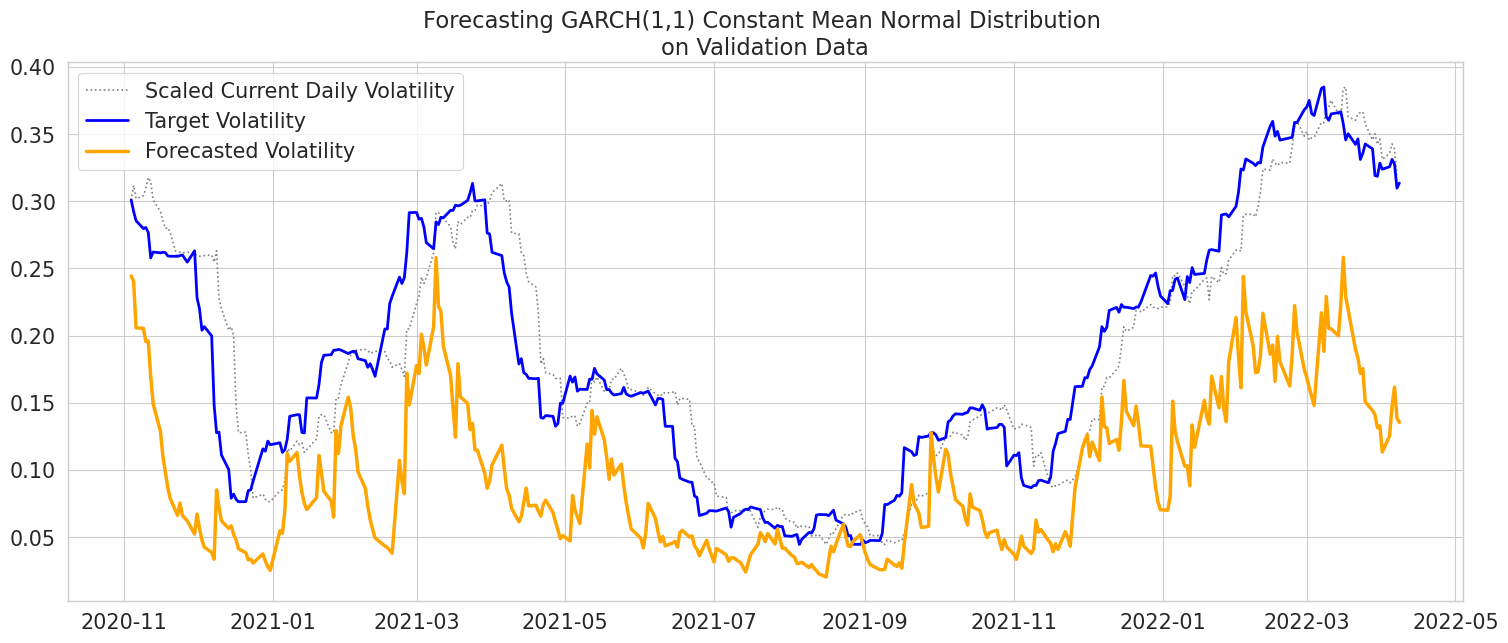

In [360]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, garch_11_preds_scaled, 
          'Forecasting GARCH(1,1) Constant Mean Normal Distribution')

To check if this is the right specifiation for the model, we need to check if residuals are normally distributed:

In [361]:
garch_11_resid = garch_11_fit.resid
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3342.08
Distribution:                  Normal   AIC:                           6692.17
Method:            Maximum Likelihood   BIC:                           6715.14
                                        No. Observations:                 2304
Date:                Sat, Jan 14 2023   Df Residuals:                     2303
Time:                        18:05:38   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1059  1.978e-02      5.353  8.672e-08 [6.711e-02,  0.145]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0617  1.472e-02      4.194  2.737e-05 [3.289e-02,9.058e-02]
alpha[1]       0.1674  2.539e-02      6.592  4.338e-11     [  0.118,  0.217]
beta[1]        0.7916  2.764e-02     28.638 2.254e-180     [  0.737,  0.846]
============================================================================

Covariance estimator: robust
"""

C:\Users\39393\AppData\Local\Temp\ipykernel_23756\1637220039.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  qqplot.show()


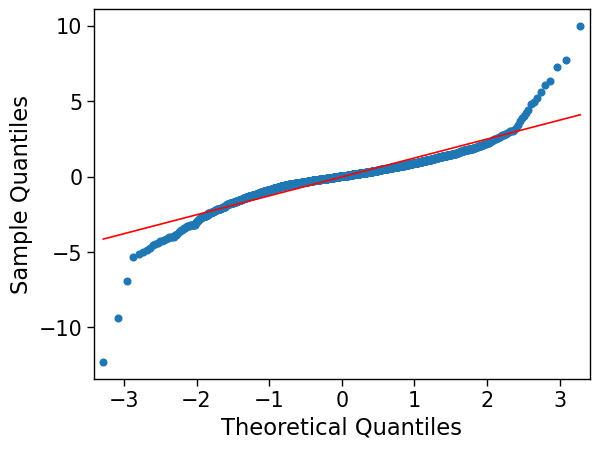

In [362]:
qqplot = sm.qqplot(garch_11_resid, line='s')
qqplot.show()

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


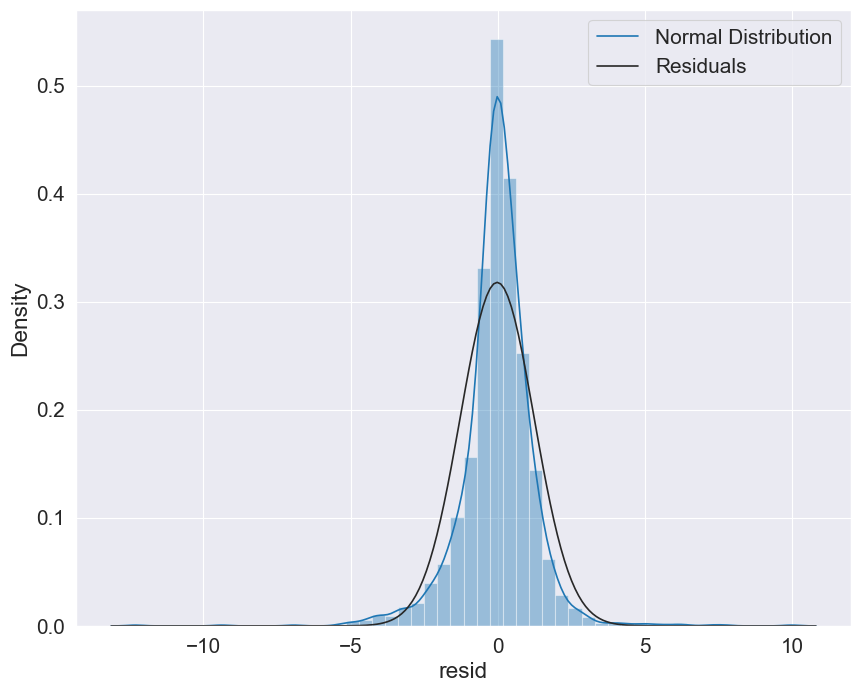

In [363]:
# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,8))
    sns.distplot(garch_11_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Residuals'))
    plt.show();

In order to be statistically accurate the Jarque-Bera Test is performed:

In [364]:
jb_test = sm.stats.stattools.jarque_bera(garch_11_resid)
jb_test

(11680.255592427578, 0.0, -0.5388015217282044, 14.959910451462415)

Since the p-value is zero, the null that the residuals comes from a normal distribution is rejected. 

In [365]:
lagged_resid = pd.DataFrame(garch_11_resid)
lagged_resid["resid_t-1"] = lagged_resid.resid.shift(1)
lagged_resid = lagged_resid.dropna()
resid_plus = []
resid_minus = []

for i in range(len(lagged_resid)):
    if lagged_resid["resid_t-1"][i] > 0:
        resid_plus.append(lagged_resid["resid_t-1"][i])
        resid_minus.append(0)
    else:
        resid_minus.append(lagged_resid["resid_t-1"][i])
        resid_plus.append(0)

lagged_resid["resid_plus"] = resid_plus
lagged_resid["resid_minus"] = resid_minus

In [366]:
import statsmodels.regression.linear_model as sm_lin

In [367]:
X = lagged_resid[["resid_minus","resid_plus"]]
model = sm_lin.OLS(abs(lagged_resid.resid), X).fit()

In [368]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  resid   R-squared (uncentered):                   0.419
Model:                            OLS   Adj. R-squared (uncentered):              0.419
Method:                 Least Squares   F-statistic:                              700.4
Date:                Sat, 14 Jan 2023   Prob (F-statistic):                   9.90e-230
Time:                        18:05:40   Log-Likelihood:                         -2670.9
No. Observations:                1943   AIC:                                      5346.
Df Residuals:                    1941   BIC:                                      5357.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [369]:
ttest_ind(lagged_resid["resid_minus"], lagged_resid["resid_plus"])

(-32.36595575485973, 1.1189162547608759e-203, 3884.0)

The p-value for the t-test is almost zero, this means that the two are statistically significant. In order to take this difference into account, we can fit a TARCH model, which allows for asymmetrics shocks (heavier for negative returns).

## TARCH Model

In [370]:
tarch = arch_model(r_train, p=1, o=1, q=1, power=1.0, dist='skewt')
tarch_fit = tarch.fit(disp = "off")
tarch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - TARCH/ZARCH Model Results                        
=========================================================================================
Dep. Variable:                           Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -2625.84
Distribution:      Standardized Skew Student's t   AIC:                           5265.69
Method:                       Maximum Likelihood   BIC:                           5304.70
                                                   No. Observations:                 1944
Date:                           Sat, Jan 14 2023   Df Residuals:                     1943
Time:                                   18:05:41   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0503  1.569e-03     32.083 7.535e-226 [4.727e-02,5.342e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0464  8.026e-03      5.778  7.563e-09  [3.064e-02,6.210e-02]
alpha[1]       0.0000  1.557e-02      0.000      1.000 [-3.052e-02,3.052e-02]
gamma[1]       0.2478  2.620e-02      9.458  3.154e-21      [  0.196,  0.299]
beta[1]        0.8698  1.359e-02     63.996      0.000      [  0.843,  0.896]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
eta            5.7705      0.796      7.249  4.199e-13 [  4.210,  7.331]
lambda        -0.2138  2.826e-02     -7.564  3.894e-14 [ -0.269, -0.158]
========================================================================

Covariance estimator: robust
"""

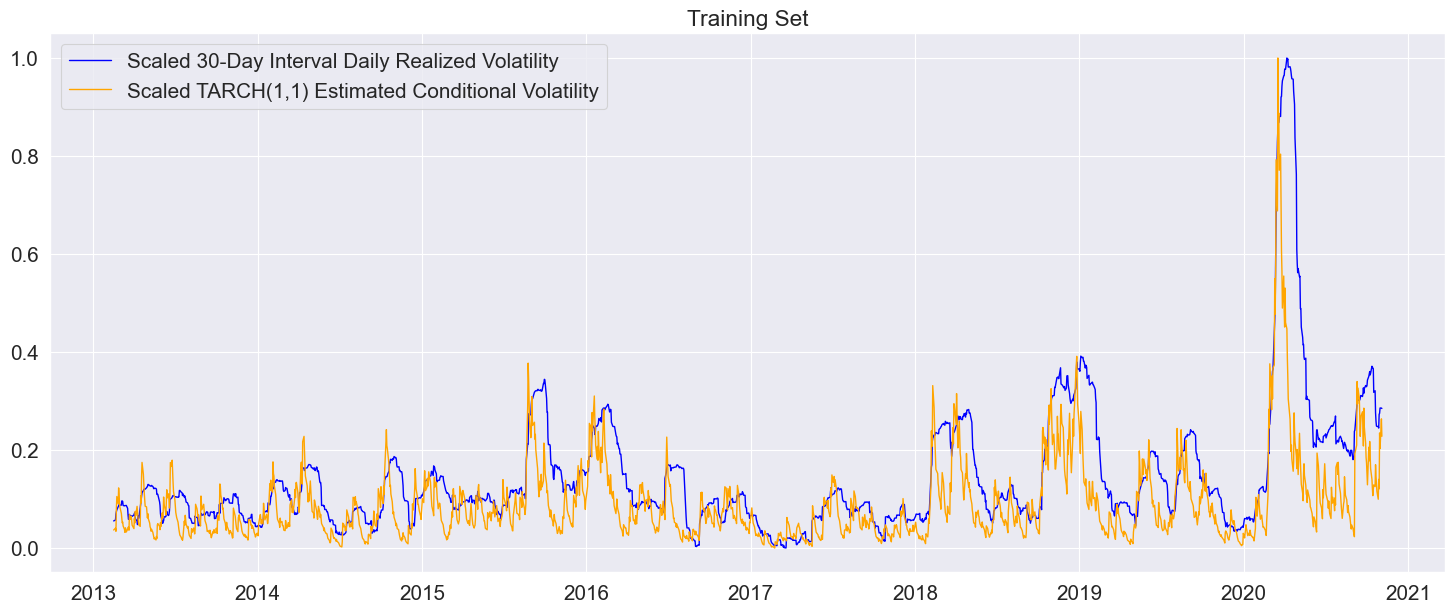

In [371]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(tarch_fit)
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

In [372]:
rolling_predictions_tarch = []

for i in range(len(val_idx)):
    idx = val_idx[i]
    train = price.Returns[:idx].dropna()
    tarch = arch_model(train, p=1, o=1, q=1, power=1.0, dist='skewt')
    tarch_fit = tarch.fit(disp = "off")
    pred = tarch_fit.forecast(horizon=n_future,
                              reindex = False,
                              method = "bootstrap").variance.values
    rolling_predictions_tarch.append(np.sqrt(np.mean(pred[-1])))

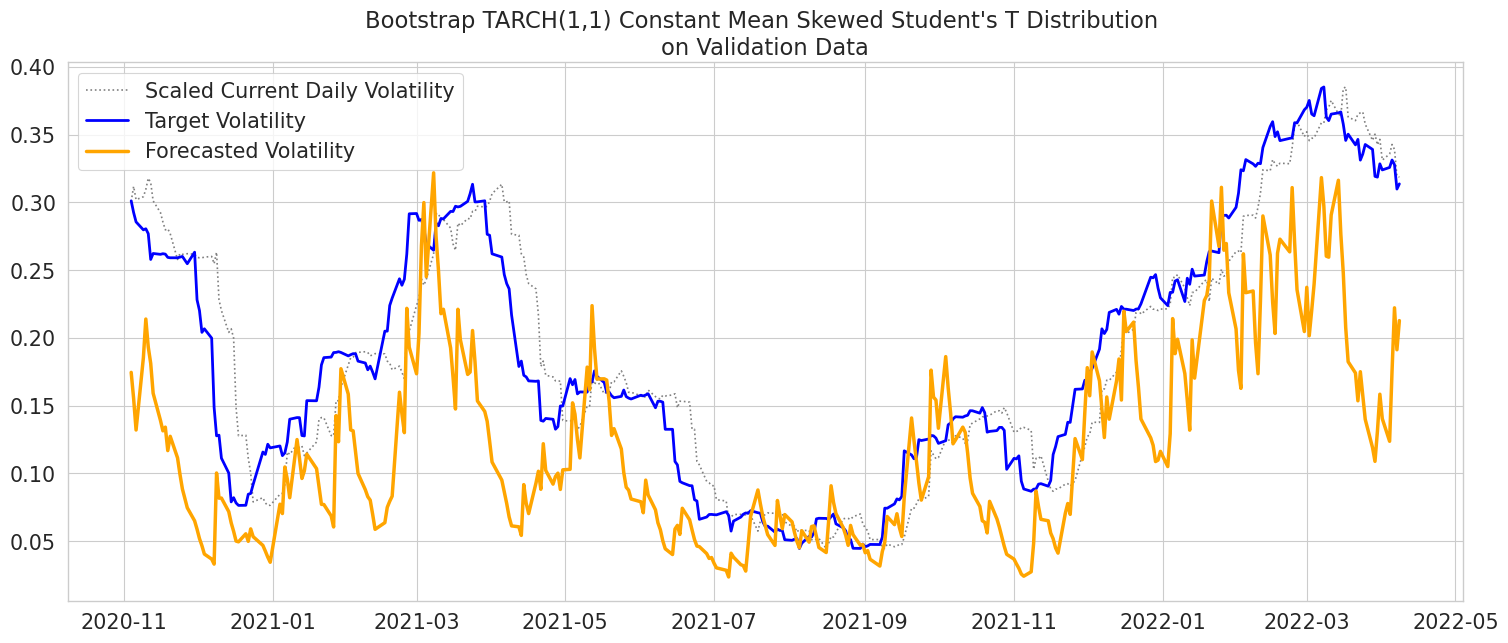

In [373]:
tarch_bs_preds = pd.DataFrame(rolling_predictions_tarch, index=val_idx)
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaled_cond_vol_tarch = transform_volatility_to_scaler(scaler_tarch, tarch_bs_preds)

viz_model(y_val_scaled, scaled_cond_vol_tarch, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

#### Hyperparameter tuning for TARCH:

In [374]:
import itertools as it
pqo_s = [p for p in it.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))

In [375]:
pqo_s = [p for p in it.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
rmspe_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # SET SEED FOR REPRODUCIBILITY
    np.random.seed(2021)

    # FITTING TARCH(p,q,o) MODEL
    ratch = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    ratch_fit = ratch.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = ratch_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = price.Returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # CONVERT PREDICTIONS
    y_preds = pd.Series(rolling_forecasts, index=val_idx)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(ratch_fit.loglikelihood)
    bic_s.append(ratch_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

In [376]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

Lowest RMSPE is 0.3729572046086281 using TARCH(1, 2, 0)


In [377]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

C:\Users\39393\AppData\Local\Temp\ipykernel_23756\1621923141.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=90)
C:\Users\39393\AppData\Local\Temp\ipykernel_23756\1621923141.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xlabels, rotation=90)
C:\Users\39393\AppData\Local\Temp\ipykernel_23756\1621923141.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(xlabels, rotation=90)


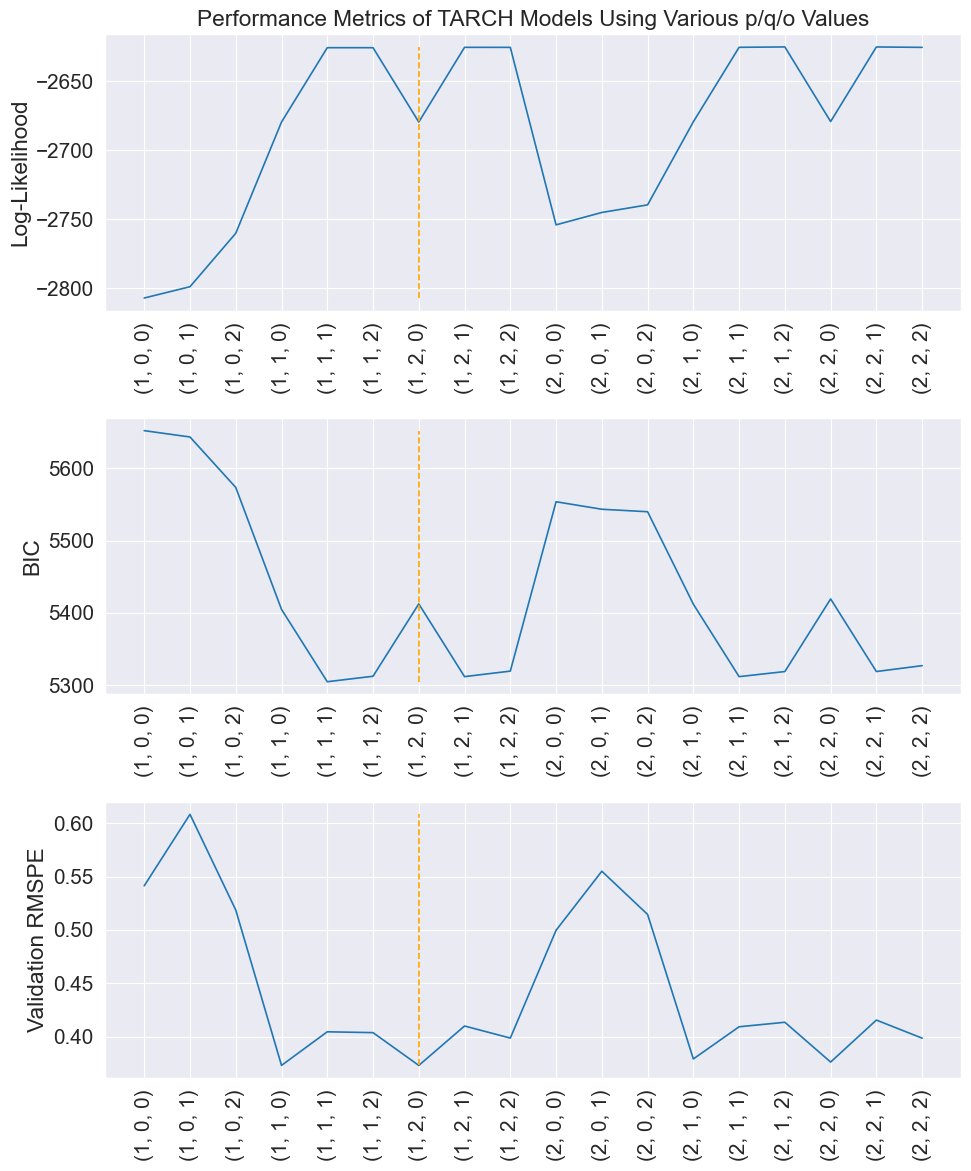

In [378]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmspe_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
    ax3.set_ylabel('Validation RMSPE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show(); 

### Best TARCH(p,o,q)

In [379]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(2021)

tarch_best = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
tarch_best_fit = tarch_best.fit(disp='off')
print(tarch_best_fit.summary())

                          Constant Mean - AVGARCH Model Results                          
Dep. Variable:                           Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                               AVGARCH   Log-Likelihood:               -2679.68
Distribution:      Standardized Skew Student's t   AIC:                           5373.36
Method:                       Maximum Likelihood   BIC:                           5412.37
                                                   No. Observations:                 1944
Date:                           Sat, Jan 14 2023   Df Residuals:                     1943
Time:                                   18:20:24   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [380]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_120, scaled_best_tarch_cond_vol = scale_tf_cond_vol(tarch_best_fit)

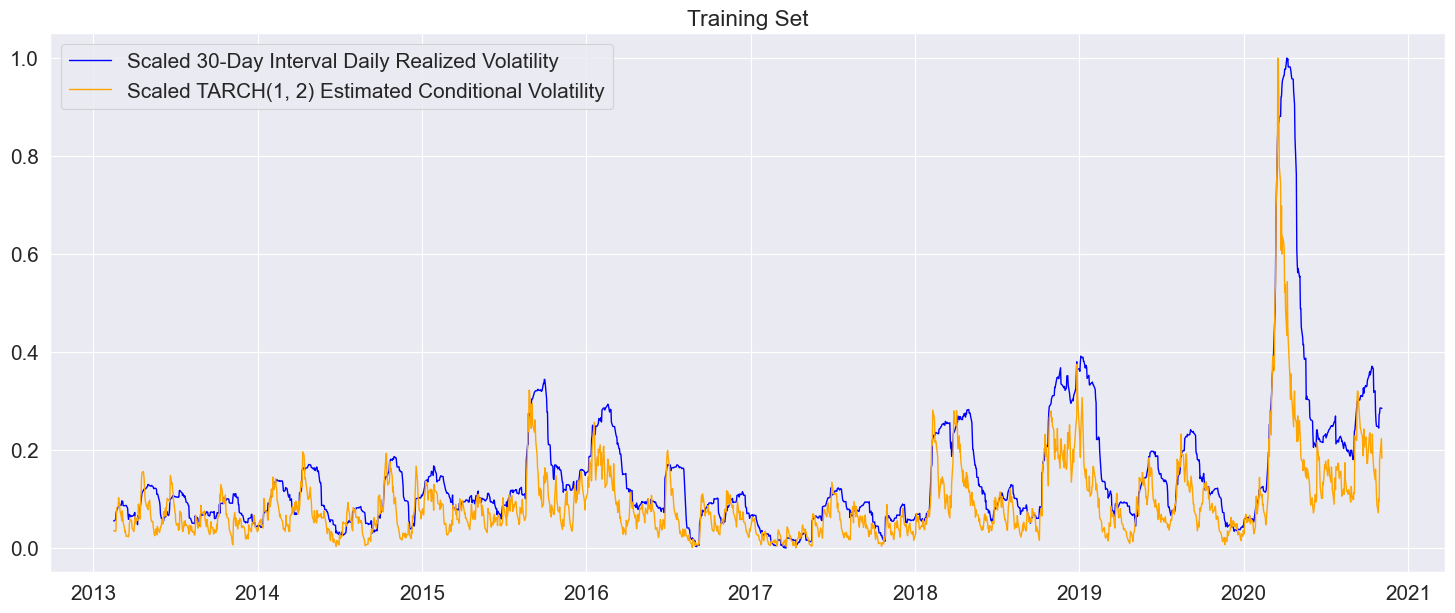

In [381]:
viz_cond_vol(scaled_best_tarch_cond_vol, f'TARCH{best_pqo[:2]}')

In [382]:
rolling_predictions_best_tarch = []

for i in range(len(val_idx)):
    idx = val_idx[i]
    train = price.Returns[:idx].dropna()
    best_tarch = arch_model(train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0, dist='skewt')
    best_tarch_fit = best_tarch.fit(disp = "off")
    pred = best_tarch_fit.forecast(horizon=n_future,
                              reindex = False,
                              method = "bootstrap").variance.values
    rolling_predictions_best_tarch.append(np.sqrt(np.mean(pred[-1])))

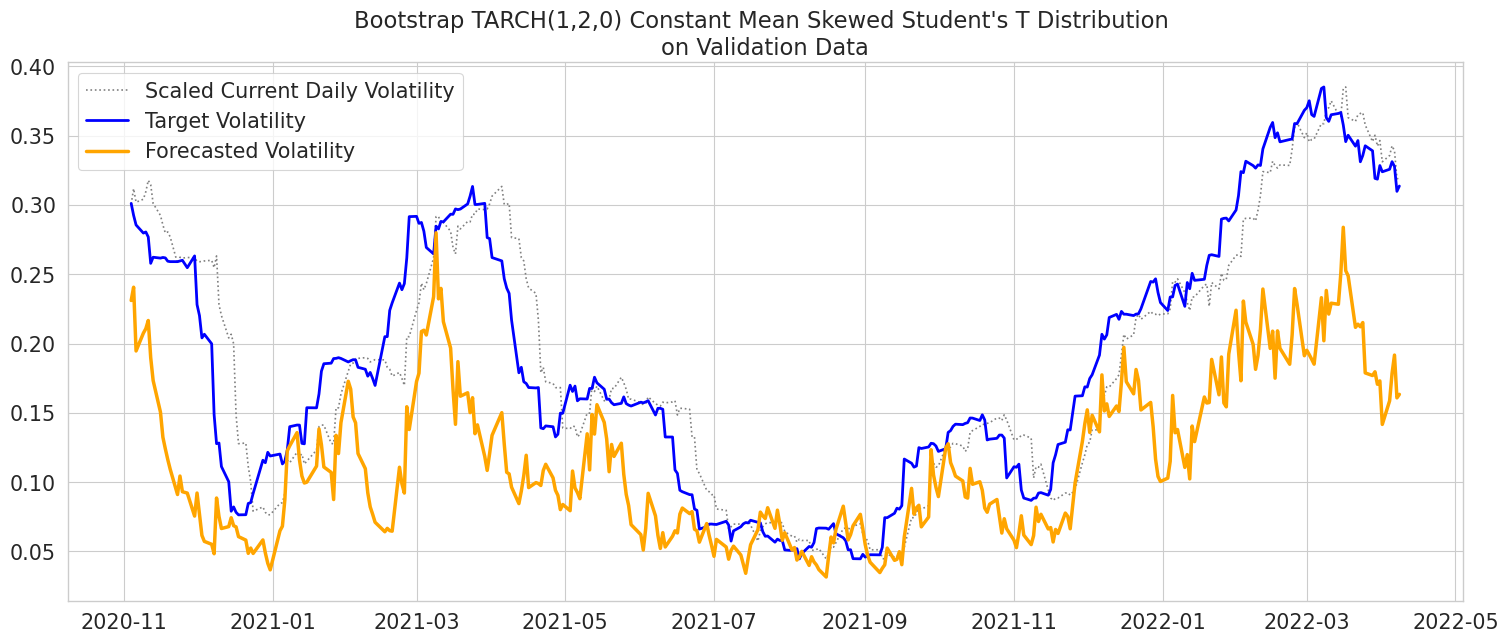

In [383]:
best_tarch_bs_preds = pd.DataFrame(rolling_predictions_best_tarch, index=val_idx)
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaled_cond_vol_best_tarch = transform_volatility_to_scaler(scaler_tarch, best_tarch_bs_preds)

viz_model(y_val_scaled, scaled_cond_vol_best_tarch, 
          "Bootstrap TARCH(1,2,0) Constant Mean Skewed Student's T Distribution")

## GJR - GARCH Model

In [384]:
gjr = arch_model(r_train, p=1, o=1, q=1, vol = "GARCH")
gjr_fit = gjr.fit(disp="off")
print(gjr_fit.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2735.85
Distribution:                  Normal   AIC:                           5481.71
Method:            Maximum Likelihood   BIC:                           5509.57
                                        No. Observations:                 1944
Date:                Sat, Jan 14 2023   Df Residuals:                     1943
Time:                        18:21:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0645  1.990e-02      3.239  1.198e-03 [2.546e-0

In [385]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(gjr_fit)

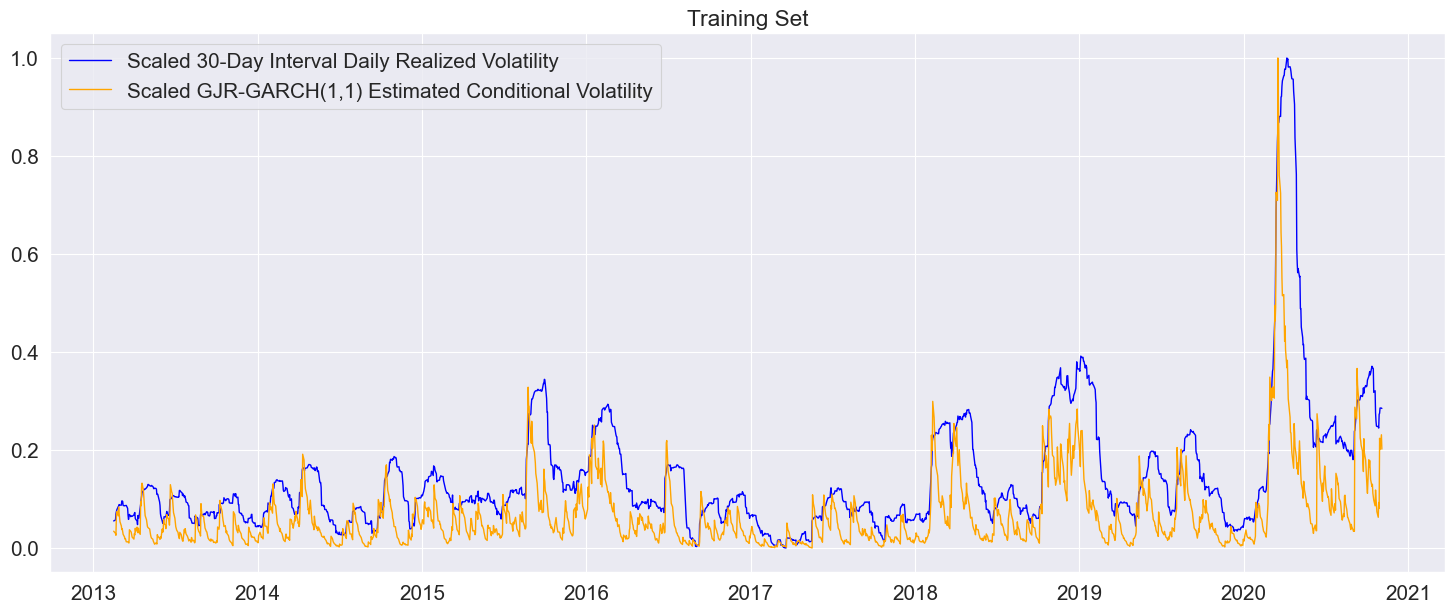

In [386]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [387]:
rolling_predictions_gjr = []

for i in range(len(val_idx)):
    idx = val_idx[i]
    train = price.Returns[:idx].dropna()
    gjr = arch_model(train, p=1, o=1, q=1, vol= "GARCH", dist = "skewt" )
    gjr_fit = gjr.fit(disp="off")
    pred = gjr_fit.forecast(horizon=n_future,
                              reindex = False).variance.values
    rolling_predictions_gjr.append(np.sqrt(np.mean(pred[-1])))

In [388]:
gjr_preds = pd.DataFrame(rolling_predictions_gjr, index=val_idx)
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_preds)

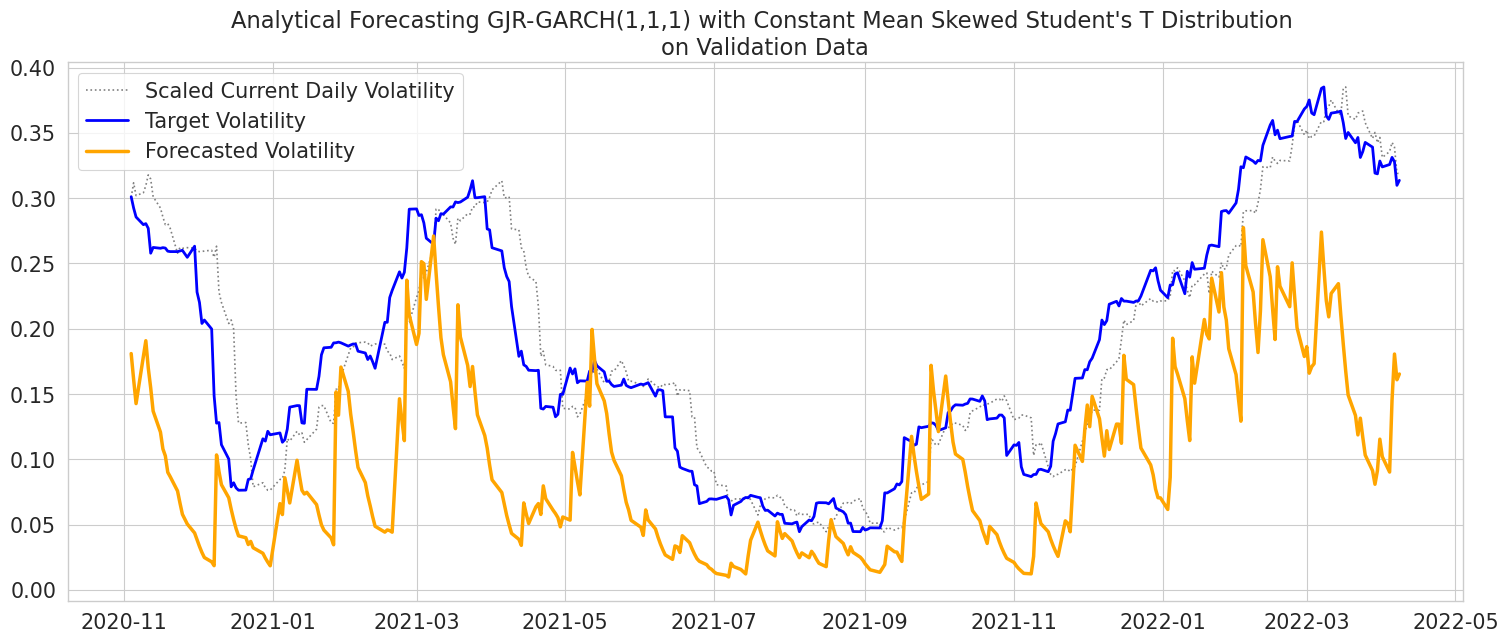

In [389]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")


## Models' comparison:

Now that we have fitted both the models, we need a way to compare them, in other words we need to evaluate the voaltility forecasts.

In order to do that, the Quasi-Likelihood Loss is used.

In [563]:
log_perf(y_val_scaled, scaled_cond_vol_tarch, 
         'Bootstrap TARCH(1,1)')

Model  Validation RMSPE  \
0  Fully Connected NN (Linear Regression), n_past=14          0.339261   
1                     LSTM layer 20 units, n_past=14          0.237995   
2                     LSTM layer 32 units, n_past=14          0.240466   
3  Bidirectional LSTM layer 64/32/16 units, n_pas...          0.273216   
4  Multivariate Bidirect LSTM 3 layers (64/32/16 ...          0.547389   
5                               Bootstrap TARCH(1,1)          0.403949   

   Validation RMSE  
0         0.040553  
1         0.031979  
2         0.031194  
3         0.030455  
4         0.069597  
5         0.085424

In [564]:
log_perf(y_val_scaled, scaled_cond_vol_best_tarch, 
         'Bootstrap TARCH(1,2,0)')

Model  Validation RMSPE  \
0  Fully Connected NN (Linear Regression), n_past=14          0.339261   
1                     LSTM layer 20 units, n_past=14          0.237995   
2                     LSTM layer 32 units, n_past=14          0.240466   
3  Bidirectional LSTM layer 64/32/16 units, n_pas...          0.273216   
4  Multivariate Bidirect LSTM 3 layers (64/32/16 ...          0.547389   
5                               Bootstrap TARCH(1,1)          0.403949   
6                             Bootstrap TARCH(1,2,0)          0.392713   

   Validation RMSE  
0         0.040553  
1         0.031979  
2         0.031194  
3         0.030455  
4         0.069597  
5         0.085424  
6         0.088061

In [565]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, garch_11_preds_scaled, 
         'GARCH(1,1)')

Model  Validation RMSPE  \
0  Fully Connected NN (Linear Regression), n_past=14          0.339261   
1                     LSTM layer 20 units, n_past=14          0.237995   
2                     LSTM layer 32 units, n_past=14          0.240466   
3  Bidirectional LSTM layer 64/32/16 units, n_pas...          0.273216   
4  Multivariate Bidirect LSTM 3 layers (64/32/16 ...          0.547389   
5                               Bootstrap TARCH(1,1)          0.403949   
6                             Bootstrap TARCH(1,2,0)          0.392713   
7                                         GARCH(1,1)          0.502673   

   Validation RMSE  
0         0.040553  
1         0.031979  
2         0.031194  
3         0.030455  
4         0.069597  
5         0.085424  
6         0.088061  
7         0.105367

In [566]:
log_perf(y_val_scaled, gjr_preds_scaled, 
         'GJR-GARCH(1,1,1)')

Model  Validation RMSPE  \
0  Fully Connected NN (Linear Regression), n_past=14          0.339261   
1                     LSTM layer 20 units, n_past=14          0.237995   
2                     LSTM layer 32 units, n_past=14          0.240466   
3  Bidirectional LSTM layer 64/32/16 units, n_pas...          0.273216   
4  Multivariate Bidirect LSTM 3 layers (64/32/16 ...          0.547389   
5                               Bootstrap TARCH(1,1)          0.403949   
6                             Bootstrap TARCH(1,2,0)          0.392713   
7                                         GARCH(1,1)          0.502673   
8                                   GJR-GARCH(1,1,1)          0.543954   

   Validation RMSE  
0         0.040553  
1         0.031979  
2         0.031194  
3         0.030455  
4         0.069597  
5         0.085424  
6         0.088061  
7         0.105367  
8         0.106587

In [568]:
print(perf_df.to_latex())

\begin{tabular}{llrr}
\toprule
{} &                                              Model &  Validation RMSPE &  Validation RMSE \\
\midrule
0 &  Fully Connected NN (Linear Regression), n\_past=14 &          0.339261 &         0.040553 \\
1 &                     LSTM layer 20 units, n\_past=14 &          0.237995 &         0.031979 \\
2 &                     LSTM layer 32 units, n\_past=14 &          0.240466 &         0.031194 \\
3 &  Bidirectional LSTM layer 64/32/16 units, n\_pas... &          0.273216 &         0.030455 \\
4 &  Multivariate Bidirect LSTM 3 layers (64/32/16 ... &          0.547389 &         0.069597 \\
5 &                               Bootstrap TARCH(1,1) &          0.403949 &         0.085424 \\
6 &                             Bootstrap TARCH(1,2,0) &          0.392713 &         0.088061 \\
7 &                                         GARCH(1,1) &          0.502673 &         0.105367 \\
8 &                                   GJR-GARCH(1,1,1) &          0.543954 &      

# Neural Networks

In [539]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [503]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [504]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [505]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [506]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past + 6)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(price.vol_current[start_idx:end_idx], 
                                price.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [507]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [508]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show()

### Fully Connected NN

In [400]:
from ann_visualizer.visualize import ann_viz

In [401]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(2021)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


In [402]:
# FIT MODEL TO TRAINING DATASET 
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

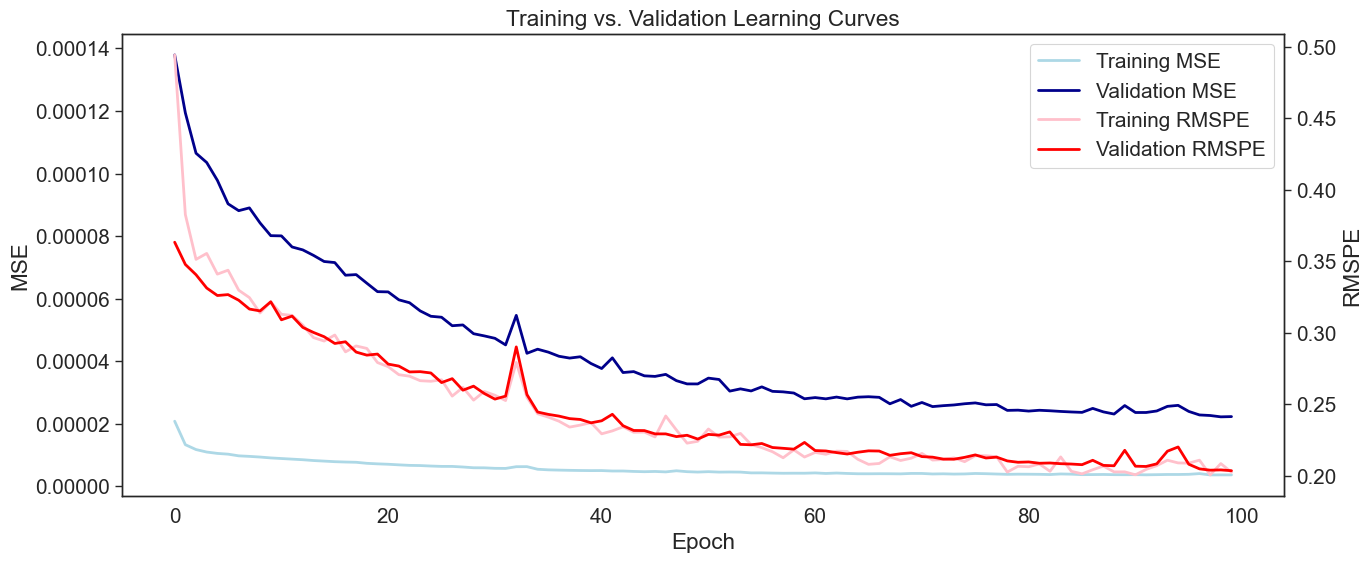

In [403]:
viz_train_val_metrics(snn_1_res)

In [404]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx)

12/12 [==============================] - 0s 2ms/step


In [405]:
# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

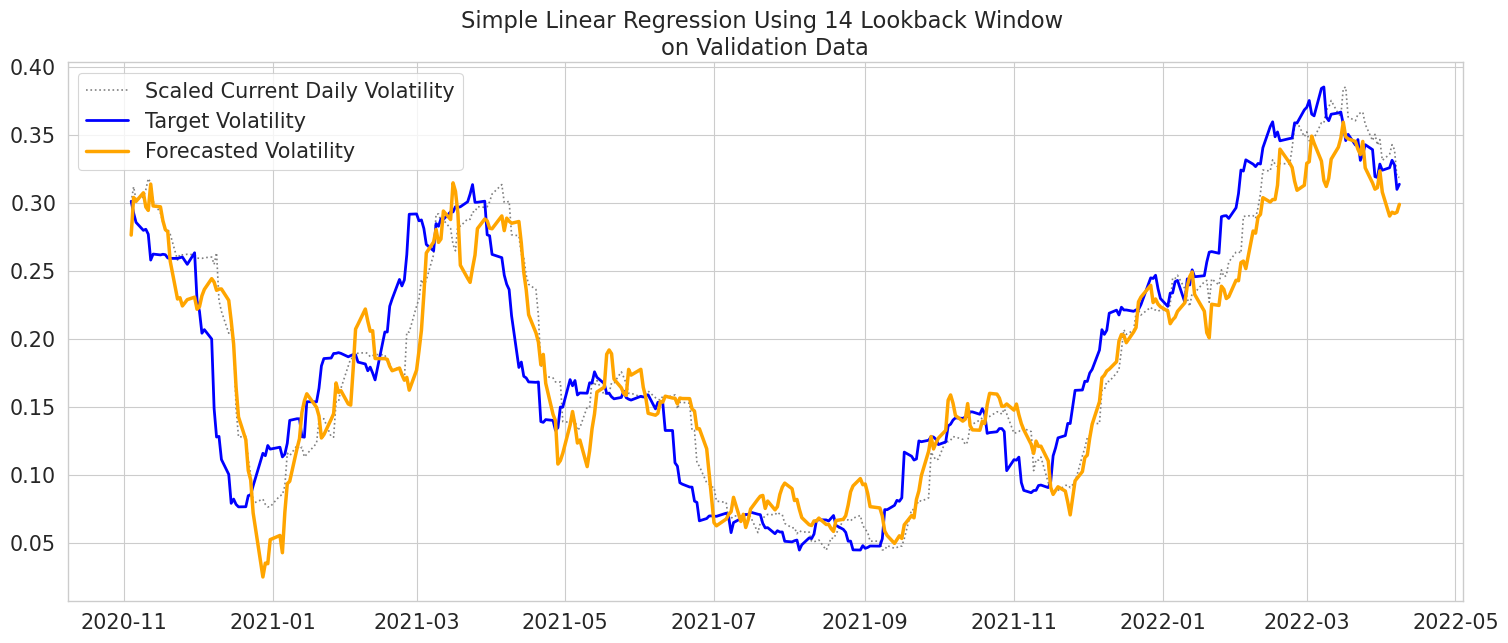

In [406]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Using {n_past} Lookback Window")

Good, but lagged, prediction

In [540]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled, 
         f"Fully Connected NN (Linear Regression), n_past={n_past}")

Model  Validation RMSPE  \
0  Fully Connected NN (Linear Regression), n_past=14          0.339261   

   Validation RMSE  
0         0.040553

#### LSTM

In [518]:
np.random.seed(2021)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, None, 1)           0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                1760      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None


In [519]:
dot_img_file = '/tmp/lstm.png'
plot_model(lstm, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [520]:
# FIT TO TRAINING DATA
lstm_1_res = lstm.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

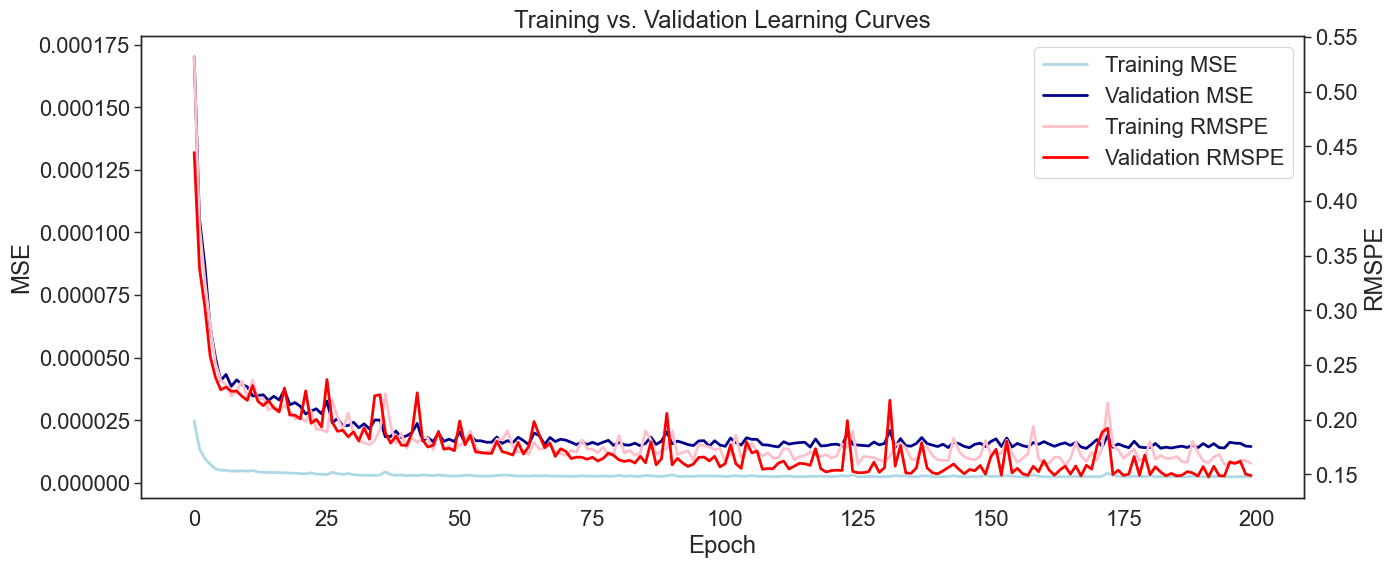

In [521]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

In [522]:
# FORECASTING ON VALIDATION SET
lstm_preds = forecast(lstm, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_preds_scaled = scale(scaler_vol, lstm_preds)

12/12 [==============================] - 1s 3ms/step


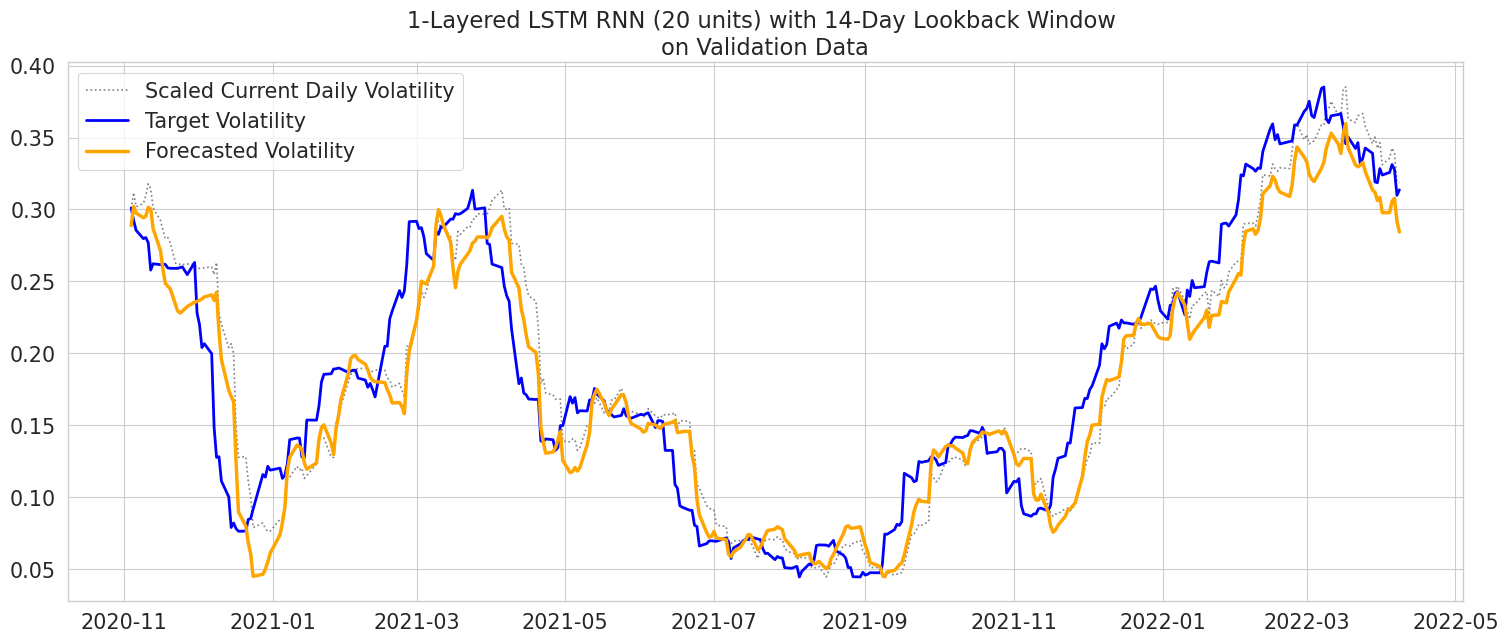

In [523]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")

Again, predictions fit closely the Target variable, but the prediction looks lagged with respect to the target volatility.

In [541]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_preds_scaled, 
         f"LSTM layer 20 units, n_past={n_past}")

Model  Validation RMSPE  \
0  Fully Connected NN (Linear Regression), n_past=14          0.339261   
1                     LSTM layer 20 units, n_past=14          0.237995   

   Validation RMSE  
0         0.040553  
1         0.031979

In [529]:
np.random.seed(2021)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_32 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(32),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_32.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=26,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_32.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, None, 1)           0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                4352      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [530]:
# FIT TO TRAINING DATA
lstm_32_res = lstm_32.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

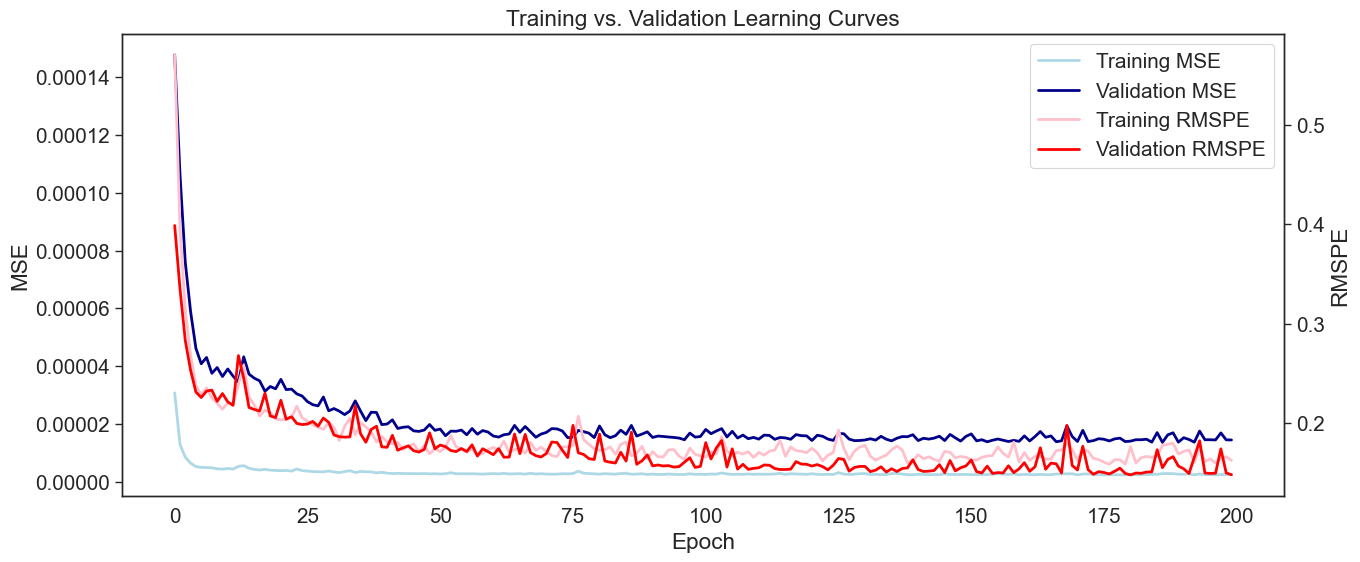

In [531]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_32_res)

In [532]:
# FORECASTING ON VALIDATION SET
lstm_32_preds = forecast(lstm_32, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_32_preds_scaled = scale(scaler_vol, lstm_32_preds)

12/12 [==============================] - 1s 4ms/step


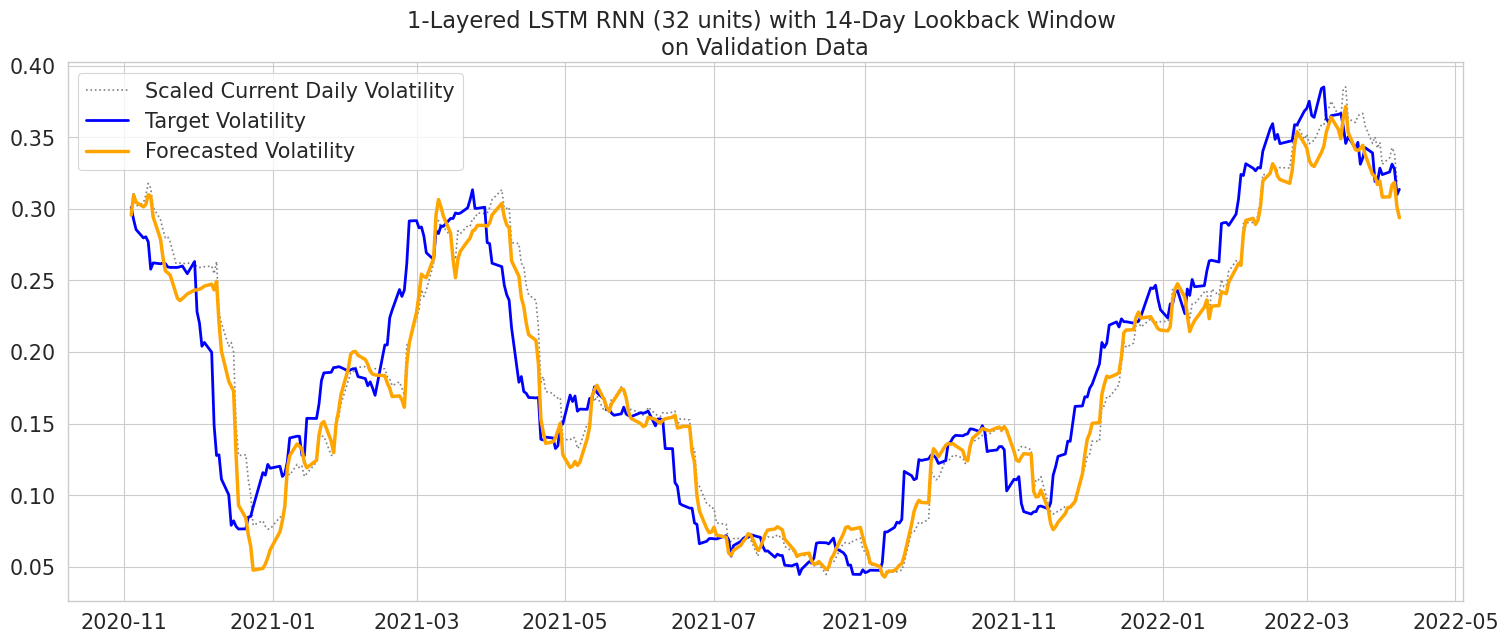

In [533]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_32_preds_scaled, 
          f"1-Layered LSTM RNN (32 units) with {n_past}-Day Lookback Window")

In [542]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_32_preds_scaled, 
         f"LSTM layer 32 units, n_past={n_past}")

Model  Validation RMSPE  \
0  Fully Connected NN (Linear Regression), n_past=14          0.339261   
1                     LSTM layer 20 units, n_past=14          0.237995   
2                     LSTM layer 32 units, n_past=14          0.240466   

   Validation RMSE  
0         0.040553  
1         0.031979  
2         0.031194

#### Bidirectional LSTM (64/32/16)

In [488]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(2021)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 3rd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         41216     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                        

In [489]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

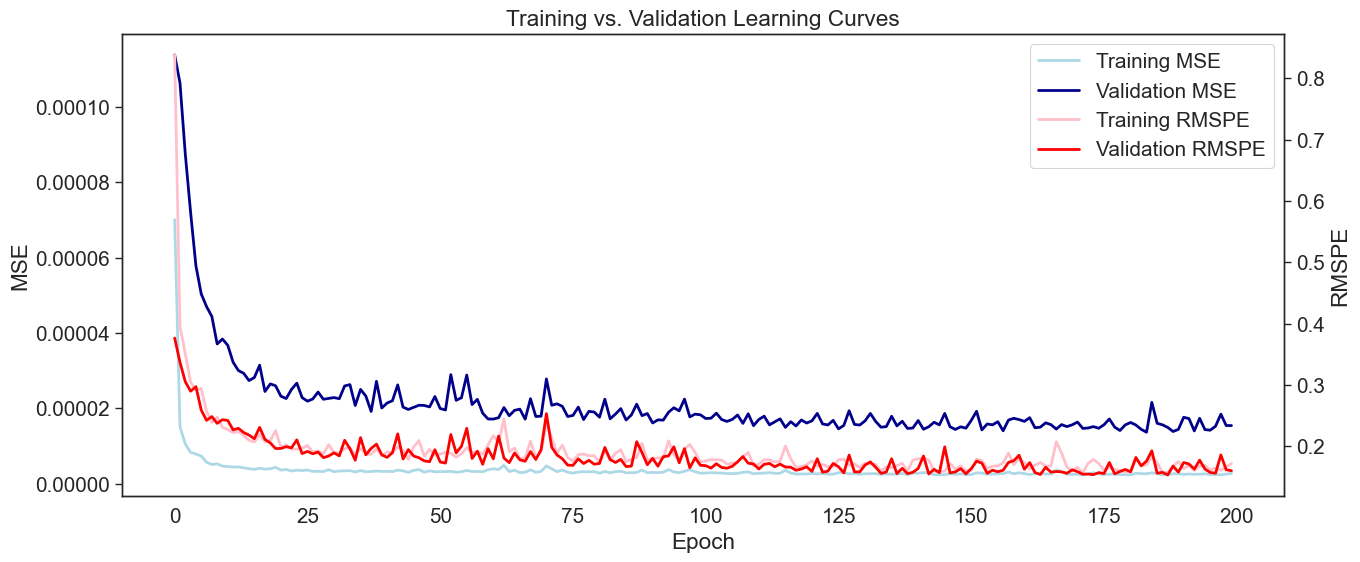

In [490]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)

In [491]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past + 12)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(price.vol_current[start_idx:end_idx], 
                                price.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [492]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 [==============================] - 5s 29ms/step


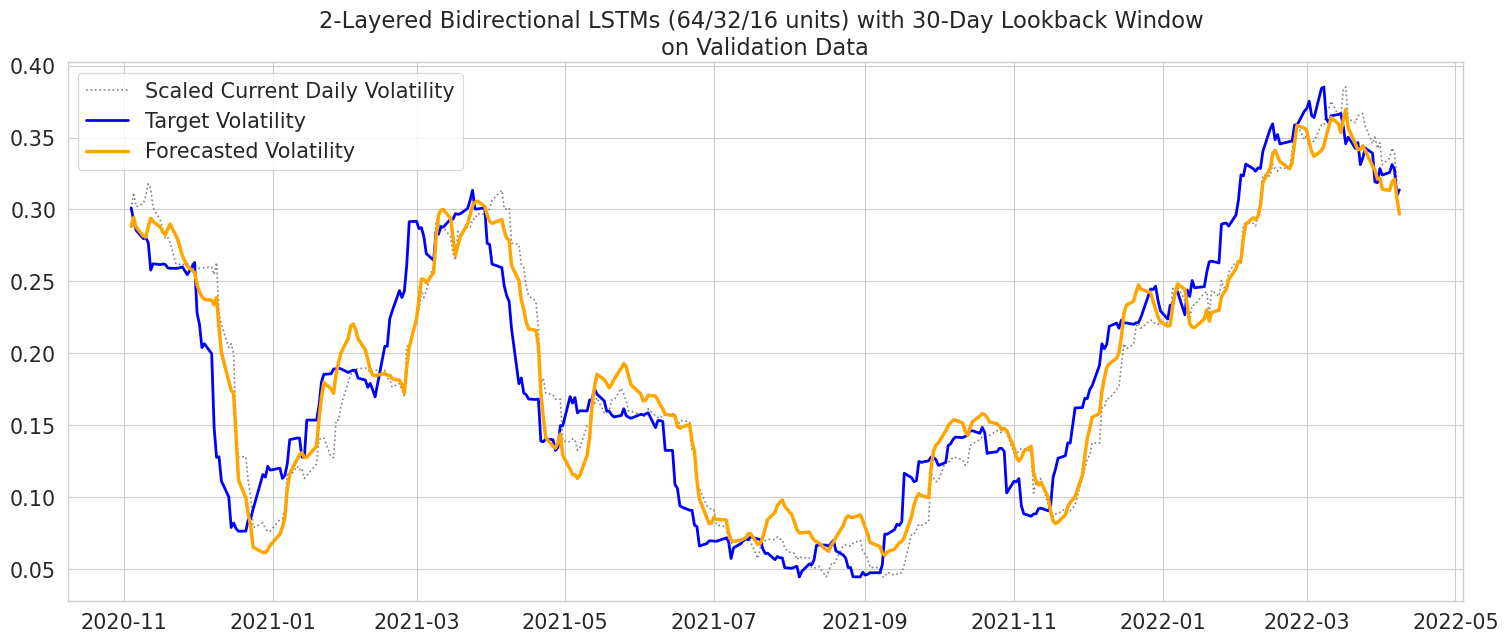

In [493]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (64/32/16 units) with {n_past}-Day Lookback Window")

In [543]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"Bidirectional LSTM layer 64/32/16 units, n_past={n_past}")

Model  Validation RMSPE  \
0  Fully Connected NN (Linear Regression), n_past=14          0.339261   
1                     LSTM layer 20 units, n_past=14          0.237995   
2                     LSTM layer 32 units, n_past=14          0.240466   
3  Bidirectional LSTM layer 64/32/16 units, n_pas...          0.273216   

   Validation RMSE  
0         0.040553  
1         0.031979  
2         0.031194  
3         0.030455

In [569]:
print(perf_df.sort_values("Validation RMSPE").to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                                             Model &  Validation RMSPE &  Validation RMSE \\
\midrule
                    LSTM layer 20 units, n\_past=14 &          0.237995 &         0.031979 \\
                    LSTM layer 32 units, n\_past=14 &          0.240466 &         0.031194 \\
Bidirectional LSTM layer 64/32/16 units, n\_past=14 &          0.273216 &         0.030455 \\
 Fully Connected NN (Linear Regression), n\_past=14 &          0.339261 &         0.040553 \\
                            Bootstrap TARCH(1,2,0) &          0.392713 &         0.088061 \\
                              Bootstrap TARCH(1,1) &          0.403949 &         0.085424 \\
                                        GARCH(1,1) &          0.502673 &         0.105367 \\
                                  GJR-GARCH(1,1,1) &          0.543954 &         0.106587 \\
Multivariate Bidirect LSTM 3 layers (64/32/16 u... &          0.547389 &         0.069597 \\
\bottomrule
\end{tabular}



## Multivariate Neural Network

#### Feature Engineering:

In [550]:
price['HL_sprd'] = np.log((price.High - price.Low) / price.Close)
price['CO_sprd'] = (price.Close - price.Open) / price.Open
price['Volume'] = np.log(price.Volume)

In [551]:
regressors = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\39393\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

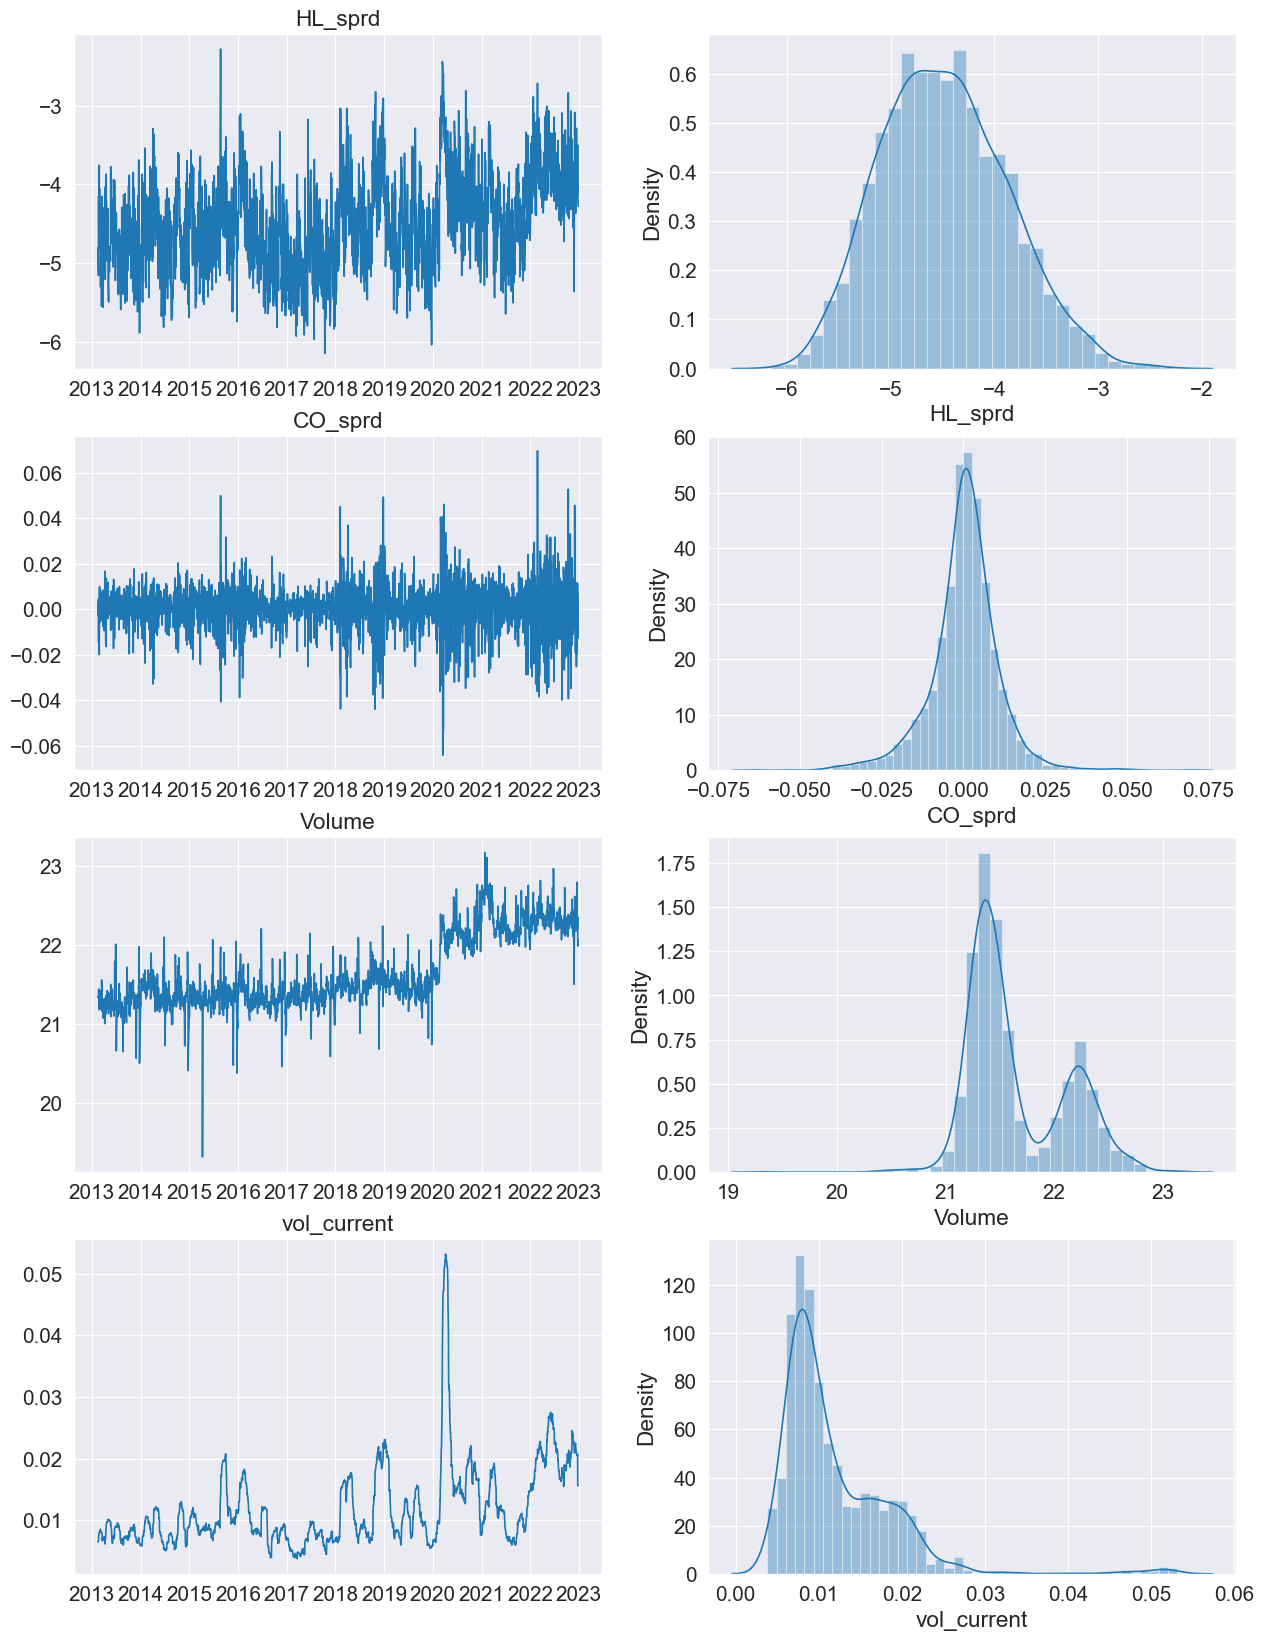

In [552]:
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(regressors):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(price[c])
        ax1.set_title(c)

        sns.distplot(price[c], ax=ax2)

    plt.show()

In [553]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = price[regressors]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [554]:
X_train.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2013-02-15 00:00:00-05:00 -4.804952 -0.002846  21.343127     0.006527
2013-02-19 00:00:00-05:00 -5.158646  0.004389  21.335116     0.006619
2013-02-20 00:00:00-05:00 -4.150334 -0.014746  21.417313     0.007219
2013-02-21 00:00:00-05:00 -4.473537 -0.006809  21.442388     0.007466
2013-02-22 00:00:00-05:00 -4.832349  0.004038  21.181640     0.007646

In [555]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past + 12)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx], 
                                price.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [556]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(2021)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
multi_lstm = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

multi_lstm.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('multi_lstm.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(multi_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          35328     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 64)           41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                        

In [557]:
# FITTING TO TRAINING DATA
lstm_5_res = multi_lstm.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

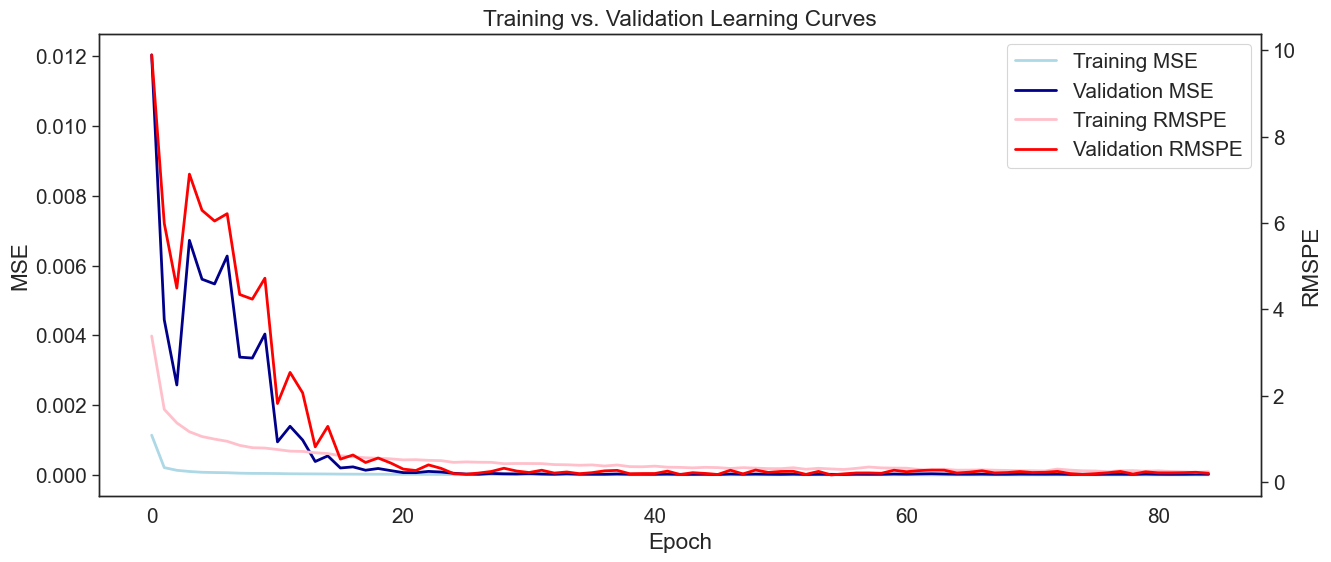

In [558]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

In [559]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(multi_lstm, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

12/12 [==============================] - 4s 20ms/step


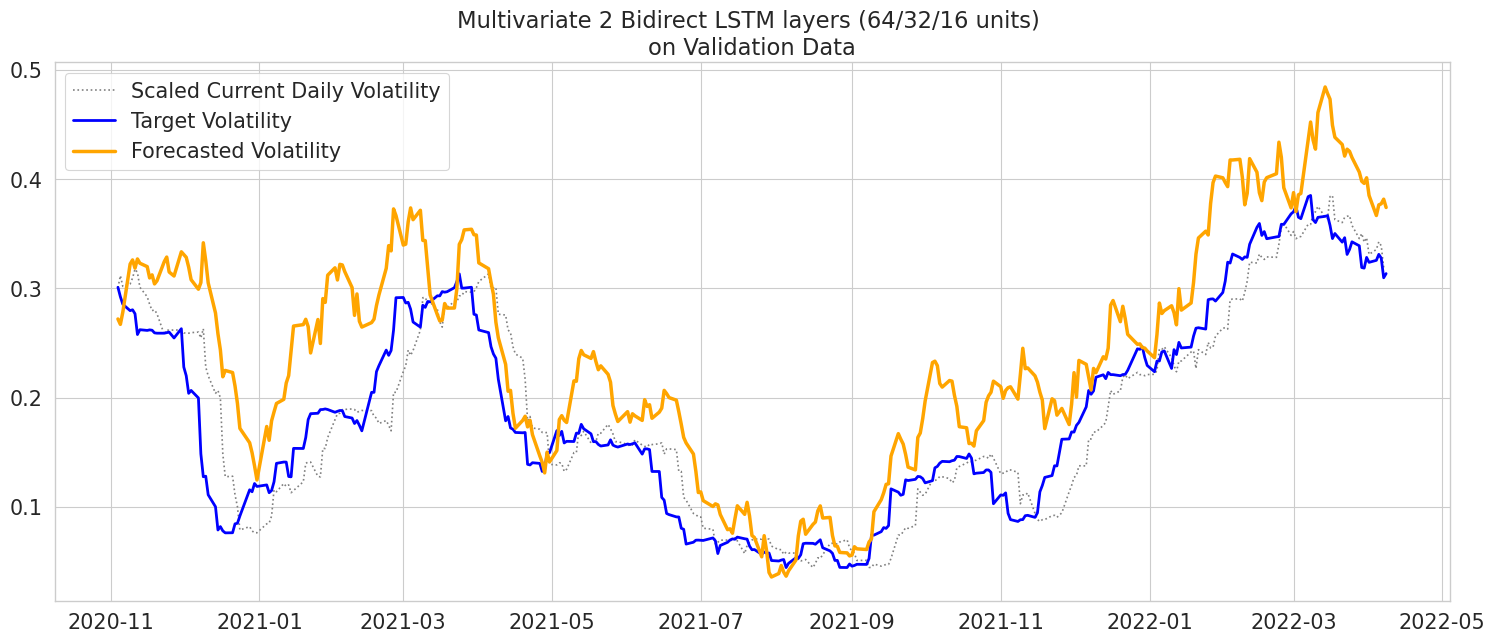

In [560]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_5_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (64/32/16 units)")

In [561]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units)")

Model  Validation RMSPE  \
0  Fully Connected NN (Linear Regression), n_past=14          0.339261   
1                     LSTM layer 20 units, n_past=14          0.237995   
2                     LSTM layer 32 units, n_past=14          0.240466   
3  Bidirectional LSTM layer 64/32/16 units, n_pas...          0.273216   
4  Multivariate Bidirect LSTM 3 layers (64/32/16 ...          0.547389   

   Validation RMSE  
0         0.040553  
1         0.031979  
2         0.031194  
3         0.030455  
4         0.069597